# Experiments w Kernel Mechanisms for External Memory

## Data

Model a "language modeling" task of predicting the next "word" in terms of a higher-order Markov models.

$$
\begin{align*}
\mathcal{M} &= \{(x^{(t)}, y^{(t)})\}_{t \in [n_m]}\\
x^{(t)} &= (x_1^{(t)}, \ldots, x_l^{(t)})\\
y^{(t)} &= (y_1^{(t)}, \ldots, y_l^{(t)}) = (x_2^{(t)}, \ldots, x_{l+1}^{(t)})\\
\end{align*}
$$

where $x_i^{(t)}$ come from a hidden markov model.
$$
\begin{align*}
x_i^{(t)} &\sim P(\cdot | x_{i-1}^{(t)}, \ldots, x_{i-m}^{(t)})
\end{align*}
$$

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from tqdm.keras import TqdmCallback

import itertools
import sys;sys.path.append('..')
import utils

import tensorflow as tf
from tensorflow.keras import layers

In [145]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Generate Data

In [146]:
n_states = 30
m = 2

state_tuples = list(itertools.product(range(n_states), repeat=m))
len(state_tuples)

900

In [147]:
transition_dict = dict()

for state_tuple in state_tuples:
    next_state = np.random.randint(n_states)
    p = np.zeros(n_states)
    p[next_state] = 1

    transition_dict[state_tuple] = p

In [148]:
def sample_markov_chain(transition_dict, prefix, num_steps):
    states_seq = prefix
    m = len(list(transition_dict.keys())[0])

    for i in range(num_steps-m):
        probabilities = transition_dict[tuple(states_seq[-m:])]
        next_state = np.random.choice(range(n_states), p=probabilities)
        states_seq.append(next_state)
    return states_seq

In [162]:
input_seq_len = 24 # length of input sequences
mem_seq_len = 2*m # length of each memory sequence
mem_size = 64 # number of memory sequences

n_train = 400
n_test = 400

def sample_seqs_dataset(n, input_seq_len):
    seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=input_seq_len+1) for _ in range(n)])

    seqs_x = seqs[:, :-1]
    seqs_y = seqs[:, 1:]

    return seqs_x, seqs_y


def sample_mem_dataset(mem_seq_len, mem_size):
    mem_seqs = np.array([sample_markov_chain(
        transition_dict, prefix=list(state_tuples[np.random.choice(len(state_tuples))]), num_steps=mem_seq_len+1) 
         for _ in range(mem_size)])
    # mem_seqs = np.repeat(np.expand_dims(mem_seqs, axis=0), axis=0, repeats=n)
    mem_seqs = mem_seqs

    mem_seqs_x = mem_seqs[:, :-1]
    mem_seqs_y = mem_seqs[:, 1:]

    return mem_seqs_x, mem_seqs_y

seqs_x_train, seqs_y_train = sample_seqs_dataset(n_train, input_seq_len)
seqs_x_test, seqs_y_test = sample_seqs_dataset(n_test, input_seq_len)



# NOTE: manually add some patterns that appears in training and testing set to memory buffer 
num_mem_from_train = 10
num_mem_from_test = 10
mem_seqs_x, mem_seqs_y = sample_mem_dataset(mem_seq_len, mem_size-num_mem_from_train-num_mem_from_test)
mem_seqs_x = np.concatenate((mem_seqs_x, seqs_x_train[n_train-num_mem_from_train:,5:9]), axis=-2)
mem_seqs_x = np.concatenate((mem_seqs_x, seqs_x_test[n_test-num_mem_from_test:,7:11]), axis=-2)
mem_seqs_y = np.concatenate((mem_seqs_y, seqs_y_train[n_train-num_mem_from_train:, 5:9]), axis=-2)
mem_seqs_y = np.concatenate((mem_seqs_y, seqs_y_test[n_test-num_mem_from_test:, 7:11]), axis=-2)


# NOTE: same memory buffer for all inputs
mem_seqs_x_train = np.repeat(np.expand_dims(mem_seqs_x, axis=0), axis=0, repeats=n_train)
mem_seqs_y_train = np.repeat(np.expand_dims(mem_seqs_y, axis=0), axis=0, repeats=n_train)
mem_seqs_x_test = np.repeat(np.expand_dims(mem_seqs_x, axis=0), axis=0, repeats=n_test)
mem_seqs_y_test = np.repeat(np.expand_dims(mem_seqs_y, axis=0), axis=0, repeats=n_test)


In [163]:
print(f'seqs_x_train.shape: {seqs_x_train.shape}; seqs_y_train.shape: {seqs_y_train.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x_train.shape: {mem_seqs_x_train.shape}; mem_seqs_y.shape: {mem_seqs_y_train.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

seqs_x_train.shape: (400, 24); seqs_y_train.shape: (400, 24)
mem_seqs_x_train.shape: (400, 64, 4); mem_seqs_y.shape: (400, 64, 4)


In [164]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test), seqs_y_test)).batch(64)


In [165]:
transition_dict = dict()

for state_tuple in state_tuples:
    next_state = np.random.randint(n_states)
    p = np.zeros(n_states)
    p[next_state] = 1

    transition_dict[state_tuple] = p

In [172]:
from kernel_memory_transformer import KernelMemoryTransformer
vocab_size = len(state_tuples)
embedding_dim = 64
memory_model1 = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [vocab_size//2,], name='kernel_memory_model')

memory_model1([seqs_x_train[:64], mem_seqs_x_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model1.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model1.summary()

Model: "kernel_memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  57600     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_17 (C  multiple                 16768     
 ausalSelfAttention)                                             
                                                                 
 global_self_attention_17 (G  multiple                 16768     
 lobalSelfAttention)                           

100%|██████████| 60/60 [24:38<00:00, 24.65s/epoch, loss=0.311, accuracy=0.921]


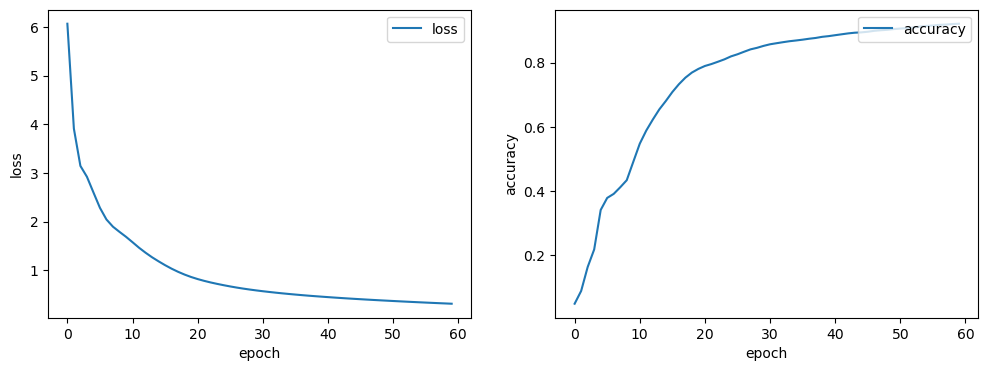

In [173]:
history1 = memory_model1.fit(train_ds, epochs=60, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history1, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));

7/7 [==============================] - 6s 741ms/step


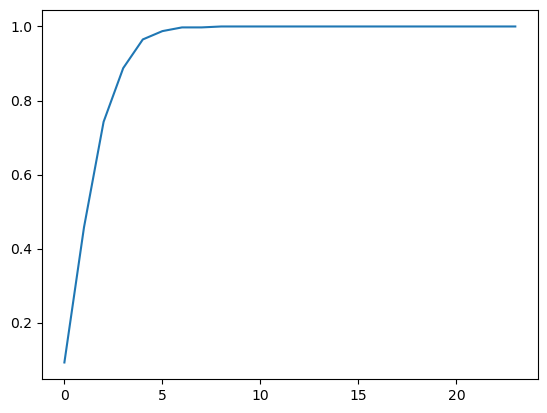

In [174]:
memory_model1.evaluate(train_ds)
memory_model1.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds = memory_model1.predict(train_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_train, axis=0)
plt.plot(acc_by_pos)

## Kernel Model 2, use mem_seq_y as value in cross attention (only embedding, no self-attention on mem_seq_y)

In [179]:
import tensorflow as tf
from tensorflow.keras import layers
from transformer_modules import AddPositionalEmbedding, MemoryAddPositionalEmbedding
from attention import GlobalSelfAttention, CausalSelfAttention, CrossAttention

class KernelMemoryTransformer_cross_y(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, ff_sizes, **kwargs):
        super().__init__(**kwargs)

        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different self-attention layers for input and memories for encoding sequences
        self.input_self_attention = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='self_attn')
        self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='mem_self_attn')

        # create cross attention layer
        self.cross_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=embedding_dim//n_heads, name='cross_attn')

        self.feedforward = tf.keras.Sequential([layers.Dense(z, activation='relu') for z in ff_sizes], name='feedforward')
        self.output_dense = layers.Dense(vocab_size, activation='softmax', name='output')

    def memory_self_attention(self, mem_seqs):
        '''apply self-attention to each memory sequence'''
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def get_cross_probs(self, embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs):
        '''compute cross attention probabilities prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory'''

        def get_memory_cross_probs(E_xt, E_yt):
            cross_attention_output = self.cross_attention_layer(
                query=embedded_input_seqs,
                key=E_xt,
                value=E_yt)
            return cross_attention_output # shape: (batch_size, seq_len, mem_len)
        
        #print(get_memory_cross_probs(embedded_mem_x_seqs[:,0,:,:], embedded_mem_y_seqs[:,0,:,:]))
        #compute cross-attention for each memory
        cross_probs = tf.map_fn(lambda xy: get_memory_cross_probs(xy[0], xy[1]), (tf.transpose(embedded_mem_x_seqs, perm=[1, 0, 2, 3]), tf.transpose(embedded_mem_y_seqs, perm=[1, 0, 2, 3])), dtype=tf.float32)
        cross_probs = tf.transpose(cross_probs, perm=[1, 0, 2, 3]) # shape: (batch_size, n_mem, mem_length, embedding_dim)

        # compute cross-probs from cross-attention via feedforward network
        cross_probs = self.feedforward(cross_probs)
        cross_probs = self.output_dense(cross_probs) # shape: (batch_size, n_mems, mem_length, vocab_size)

        return cross_probs

    def get_observed_cross_probs(self, cross_probs, seq_input):
        '''given the cross_probs tensor, extract the components coresponding to the observed sequence'''

        cross_probs_observed = tf.transpose(cross_probs, perm=(1,0,2,3))
        cross_probs_observed = tf.map_fn(lambda x: tf.gather(x, indices=seq_input, axis=-1, batch_dims=2), cross_probs_observed)
        cross_probs_observed = tf.transpose(cross_probs_observed, perm=(1,0,2))
        return cross_probs_observed

    def compute_mem_attention_scores(self, cross_probs_observed):
        '''compute memory-level attention scores, alpha_it (i is position in input sequence, t is memory index)'''

        log_cross_probs_observed = tf.math.log(cross_probs_observed)
        w_it = tf.math.cumsum(log_cross_probs_observed, axis=-1, exclusive=True)
        alpha_it = tf.nn.softmax(w_it, axis=1) # shape [batch_size, num_mems, in_seq_length]
        return alpha_it

    def call(self, inputs):
        seq_input, memory_input_x, memory_input_y = inputs

        # embed input sequences and memory sequences
        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_input_x)
        embedded_mem_y_seqs = self.embedder(memory_input_y)

        # add positional embeddings
        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)

        # encode via self-attention
        embedded_input_seqs = self.input_self_attention(embedded_input_seqs) # shape: (batch_size, input_length, embedding_dim)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs) # shape: (batch_size, num_memories, memory_length, embedding_dim)

        # compute prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory
        cross_probs = self.get_cross_probs(embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs)

        # compute prob(x_{i+1} | x_{1:i}, x^{(t)}) for each memory
        cross_probs_observed = self.get_observed_cross_probs(cross_probs, seq_input)

        # compute alpha_it = softmax(w_it) where w_it = sum_{j=1}^{i-1} log prob(x_{j+1} | x_{1:j}, x^{(t)})
        alpha_it = self.compute_mem_attention_scores(cross_probs_observed)
        self.alpha_it = alpha_it
        
        # compute prob(x_{i+1} | x_{1:i}, {x^{(t)}}_t) = \sum_t alpha_it * prob(x_{i+1} = . | x_{1:i}, x^{(t)})
        output = tf.reduce_sum(tf.multiply(tf.expand_dims(alpha_it, axis=-1), cross_probs), axis=1)

        return output


In [180]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train, mem_seqs_x_train, mem_seqs_y_train), seqs_y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test, mem_seqs_x_test, mem_seqs_y_test), seqs_y_test)).batch(64)


memory_model2 = KernelMemoryTransformer_cross_y(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [vocab_size//2,], name='kernel_memory_model_cross_y')

memory_model2([seqs_x_train[:64], mem_seqs_x_train[:64], mem_seqs_y_train[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
memory_model2.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
memory_model2.summary()

Model: "kernel_memory_model_cross_y"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  57600     
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_18 (C  multiple                 16768     
 ausalSelfAttention)                                             
                                                                 
 global_self_attention_18 (G  multiple                 16768     
 lobalSelfAttention)                   

In [181]:
history2 = memory_model2.fit(train_ds, epochs=70, verbose=0, callbacks=[TqdmCallback()])
utils.plot_history(history2, plot_attrs=('loss', 'accuracy'), val=False, figsize=(12,4));
# I mistakenly interrupted, but the model accuracy suddenly drops from 74% to around 4% and then to 1% starting from epoch 62

 94%|█████████▍| 66/70 [27:50<01:25, 21.25s/epoch, loss=nan, accuracy=0.0119] 

KeyboardInterrupt: 

7/7 [==============================] - 6s 743ms/step


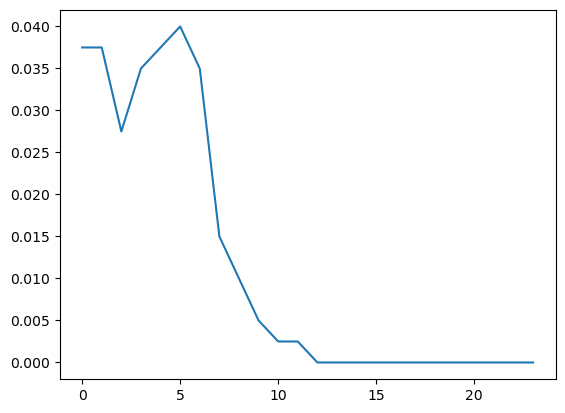

In [182]:
memory_model2.evaluate(train_ds)
memory_model2.evaluate(test_ds)

# plot accuracy as a function of position in sequence
preds = memory_model2.predict(train_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == seqs_y_train, axis=0)
plt.plot(acc_by_pos)

## Attention visualization

In [254]:

def plot_seq_attention(attn_, mem_seqs_x, train_seqs_x):
    num_mem_seqs = attn_.shape[0]
    fig, ax = plt.subplots(figsize=(num_mem_seqs/8,train_seqs_x.shape[-1]*20))
    im = ax.imshow(attn_, cmap='gray', vmin=0, vmax=1)
    ax.set_yticks(range(len(mem_seqs_x)))
    ax.set_xticks(range(len(train_seqs_x)))
    ax.set_yticklabels([tuple(x) for x in mem_seqs_x]);
    ax.set_xticklabels(train_seqs_x);

    ax.set_xlabel('input sequence')
    ax.set_ylabel('memory sequences')
    ax.set_title('attention over sequences')

    fig.colorbar(im, ax=ax)
    

def plot_attention(sample_input_index, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model):
    """
    choose sample input and plot the attention associated to the argmax probability vocab at each input position 
    (memory_seq versus each input element), call plot_seq_attention as subfunction
    """
    b = sample_input_index
    sample_input = seqs_x_train[b:b+1]
    print("sample_input: ",sample_input)
    sample_mem_seq_x = mem_seqs_x_train[b:b+1]
    sample_mem_seq_y = mem_seqs_y_train[b:b+1]

    pred = memory_model([sample_input, sample_mem_seq_x])
    pred = np.argmax(pred, axis=-1)
    print(f'prediction: {pred[0]}')
    print(f'y: {seqs_y_train[b]}')
    print(pred[0] == seqs_y_train[b])
    attn_ = memory_model.alpha_it[0]
    #print(attn_output_seq.shape)
    plot_seq_attention(attn_, sample_mem_seq_x[0], sample_input[0])


sample_input:  [[ 3  6 28  9 18 25  6 13 18  6 19 24 25 20 13 15 11 20 19  1 17 12 10 23]]
prediction: [23  0  9 18 25  6 13 18  6 19 24 25 20 13 15 11 20 19  1 17 12 10 23 27]
y: [ 6 28  9 18 25  6 13 18  6 19 24 25 20 13 15 11 20 19  1 17 12 10 23 27]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[11  0 12 11 19  1 17 12 10 23 27 25 27  2  6 16 28 12  9 28 21 28 13 20]]
prediction: [ 0 12 11 19  1 17 12 10 23 27 25 27  2  6 16 28 12  9 28 21 28 13 20 17]
y: [ 0 12 11 19  1 17 12 10 23 27 25 27  2  6 16 28 12  9 28 21 28 13 20 17]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[17  4 29 12 18 13  4  2 23 22 16 23  5 15 29  3 11 25 10  3  1 15  5 12]]
prediction: [26 29 12 18 13  4  2 23 22 16 23  5 15 29  3 11 25 10  3  1 15  5 12 10]
y: [ 4 29 12 18 13  4

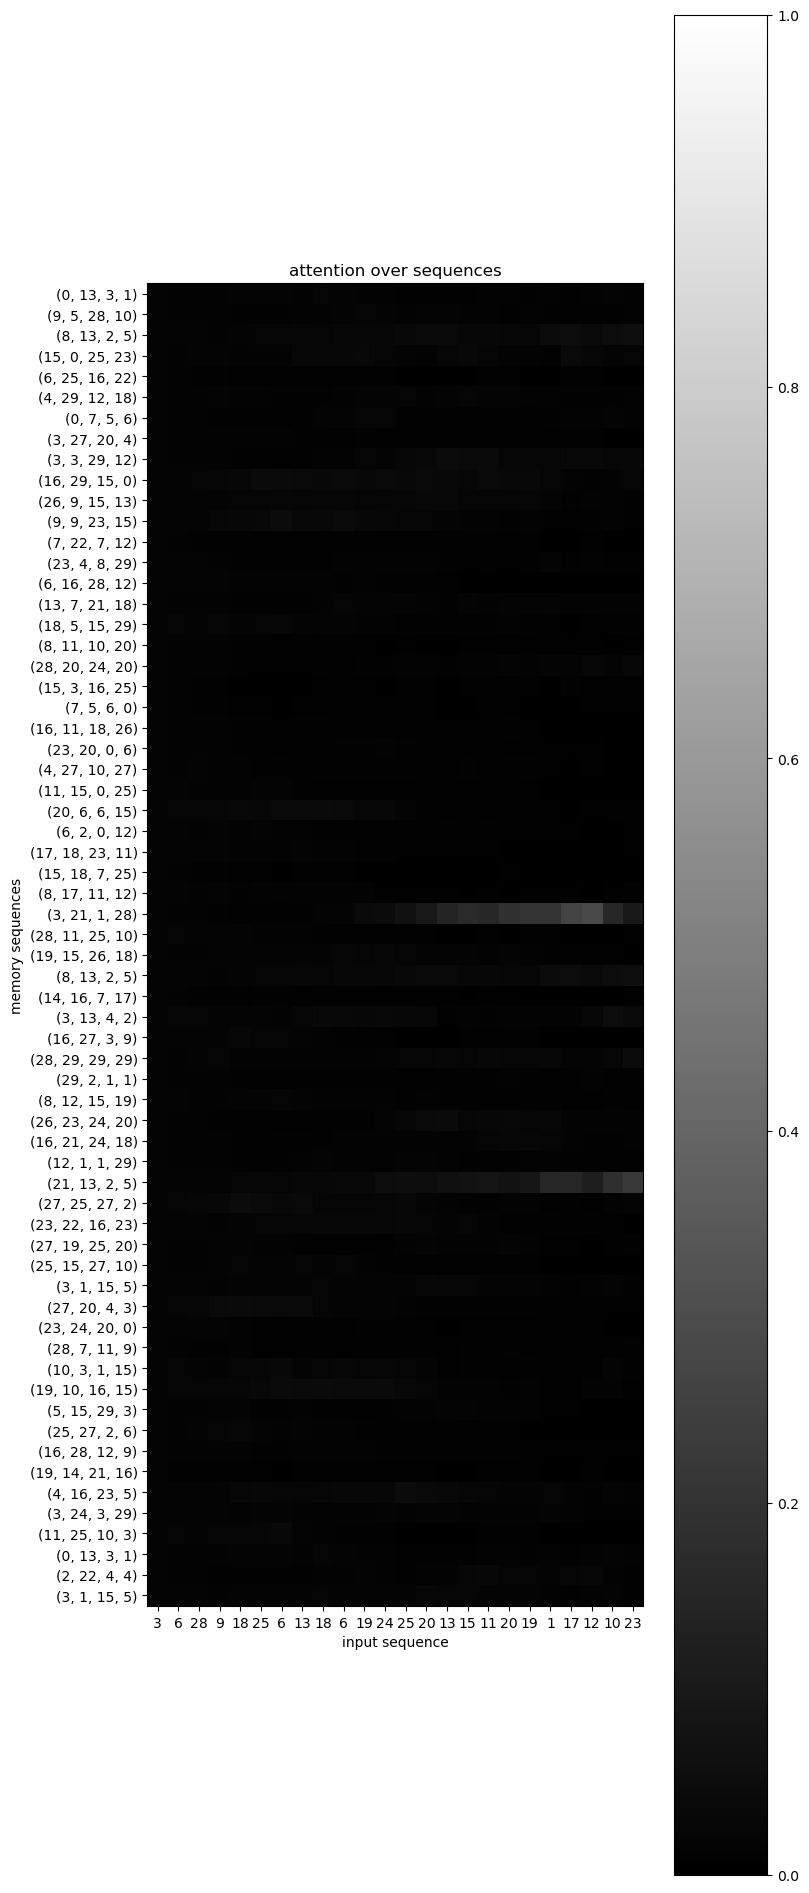

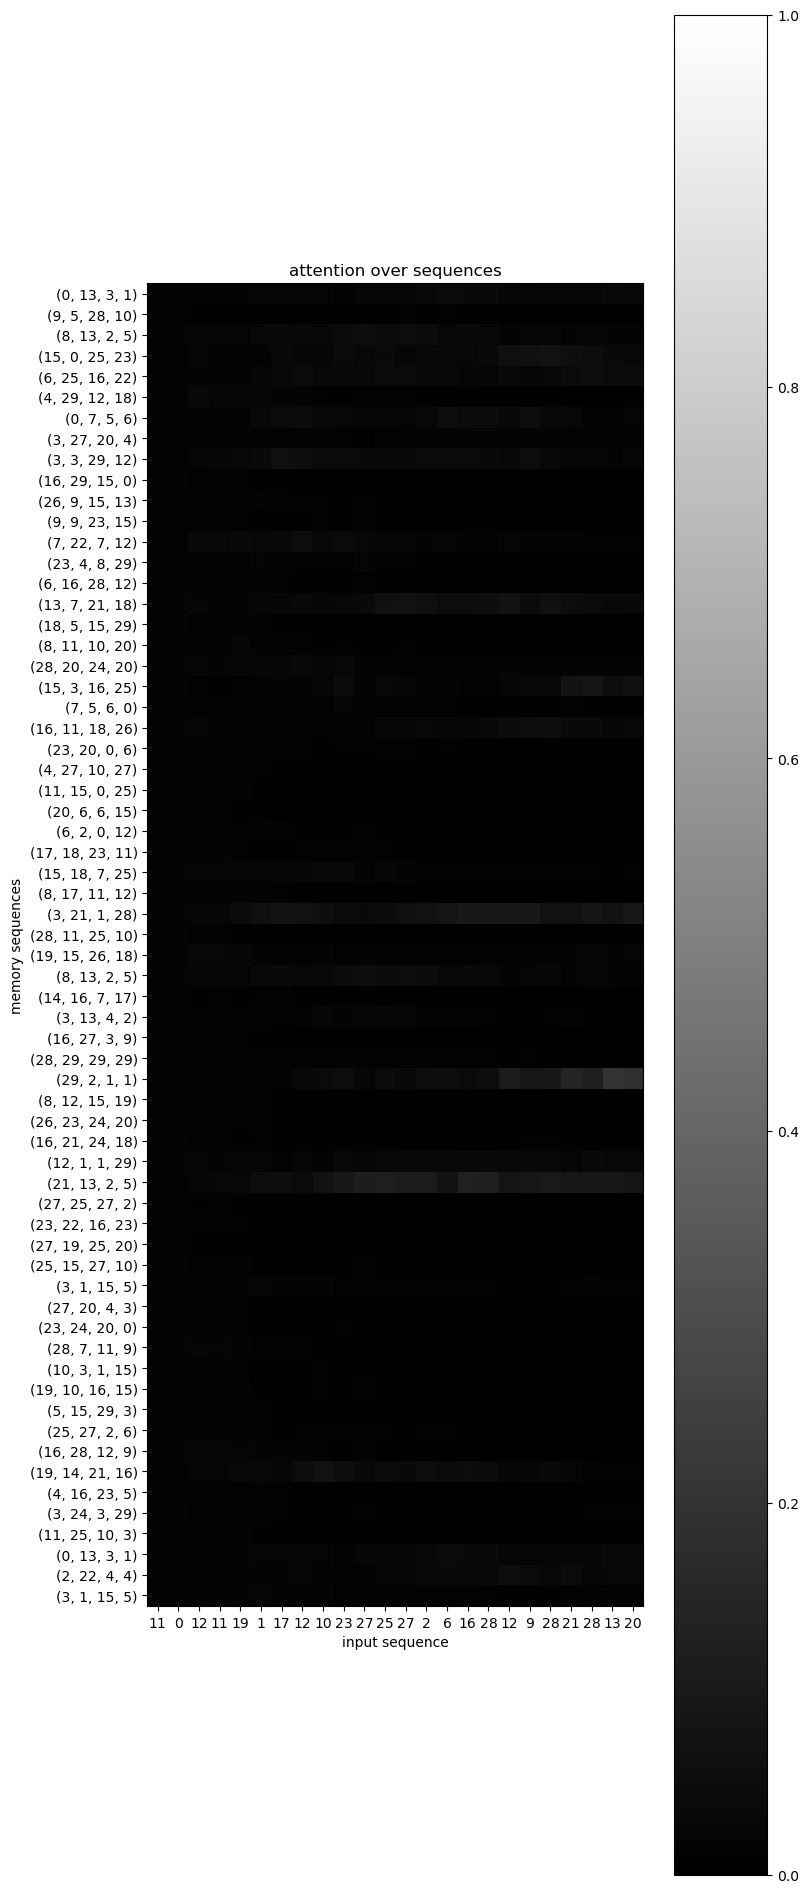

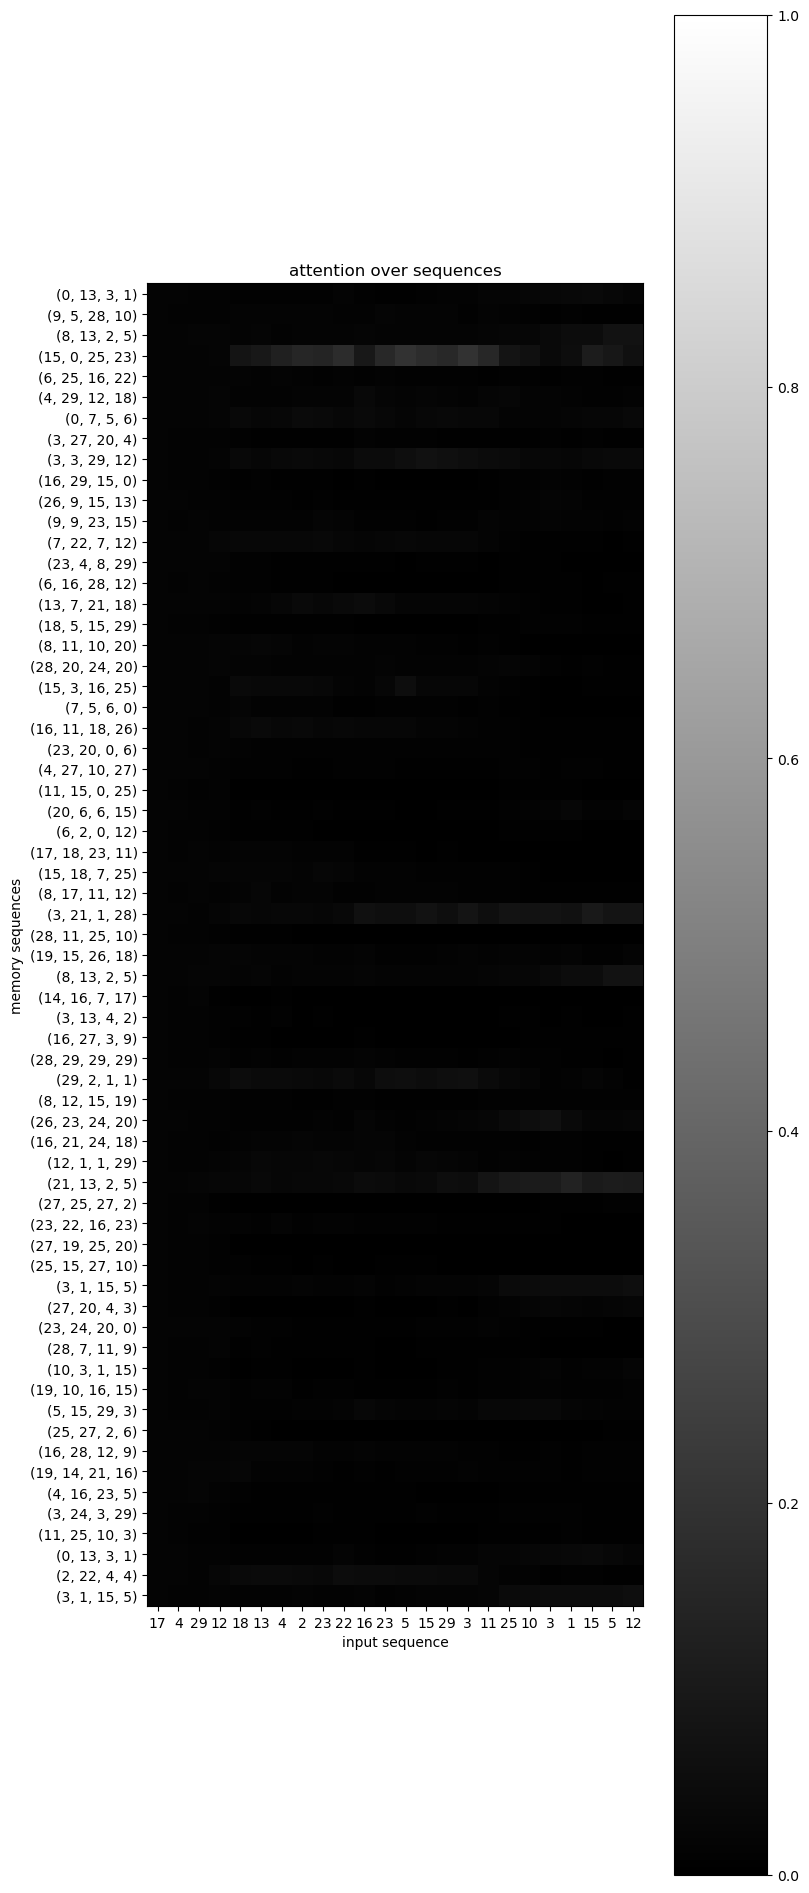

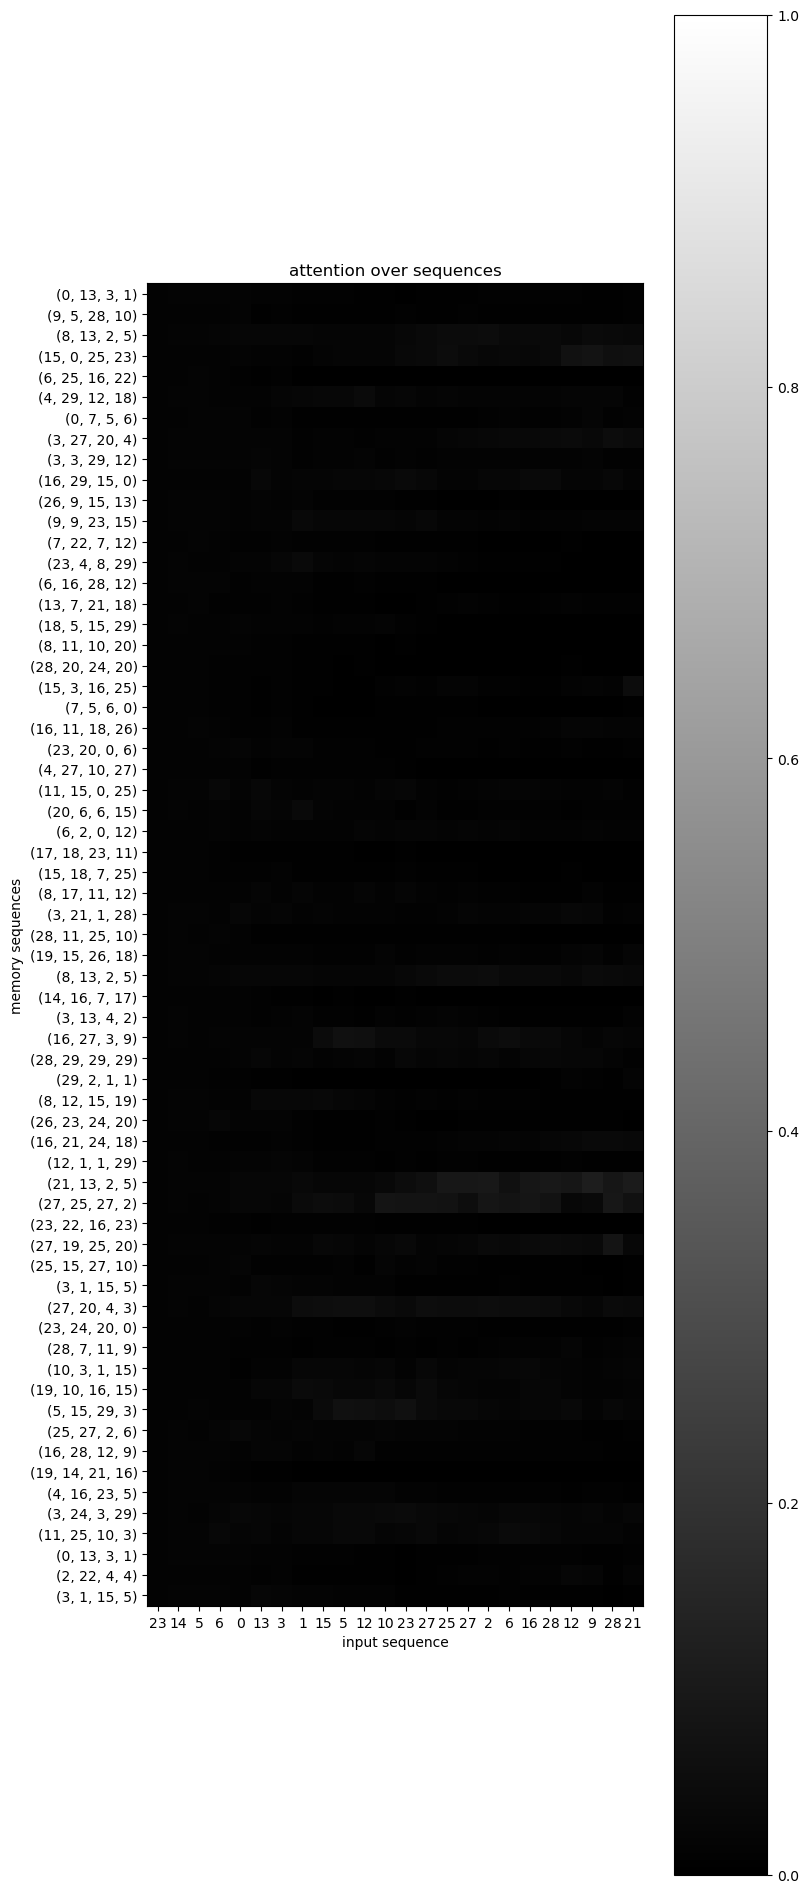

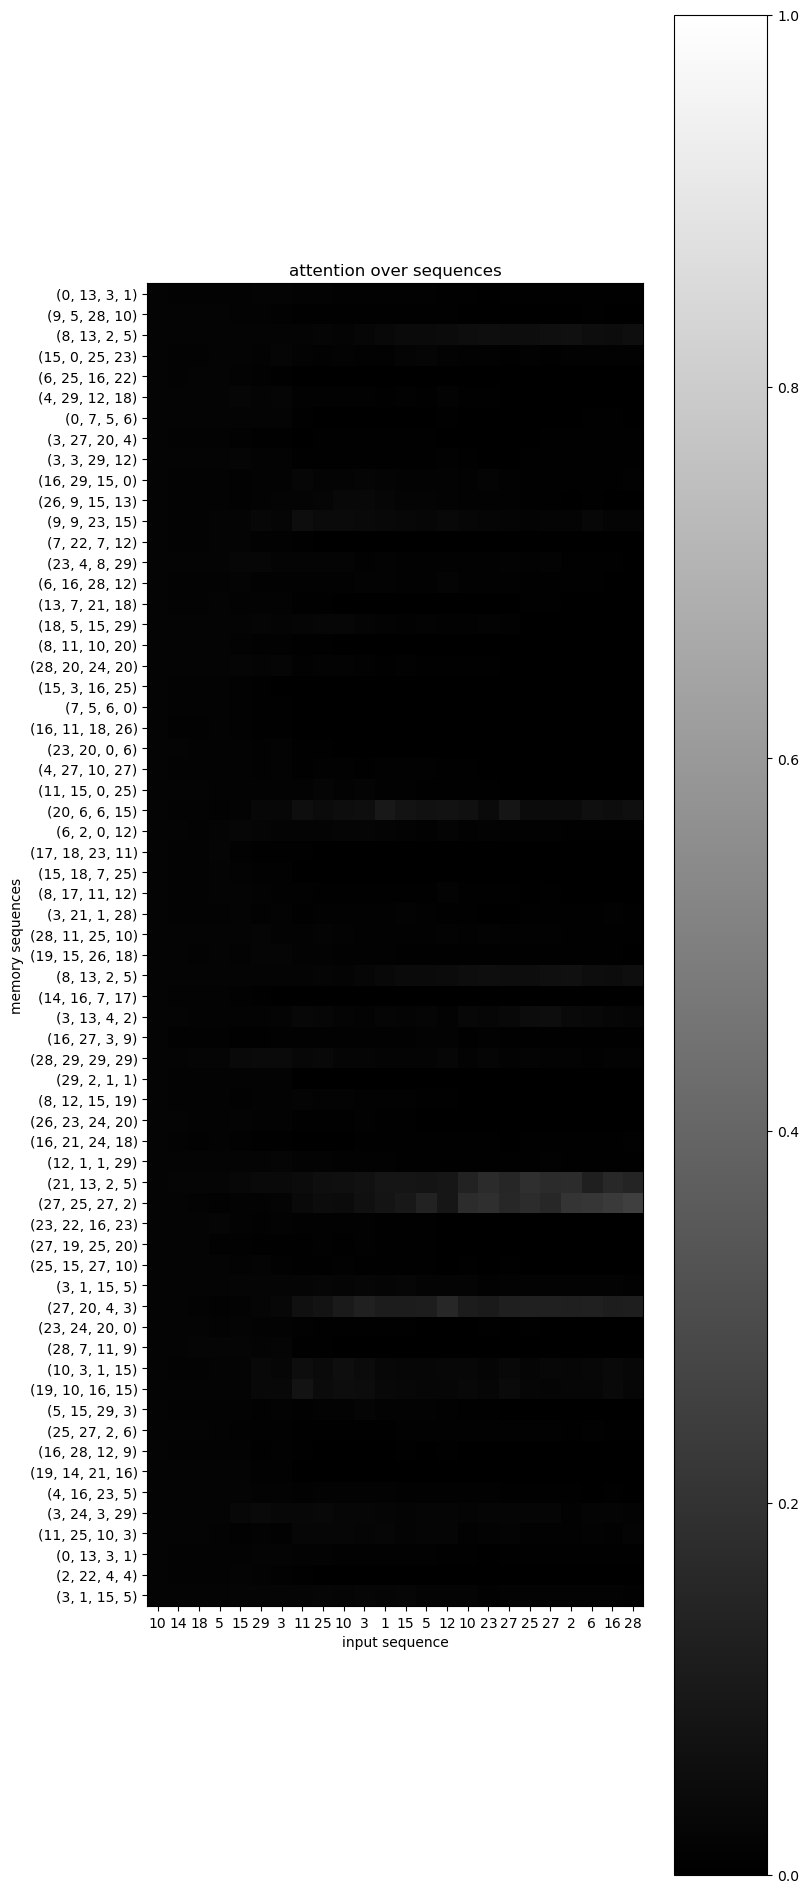

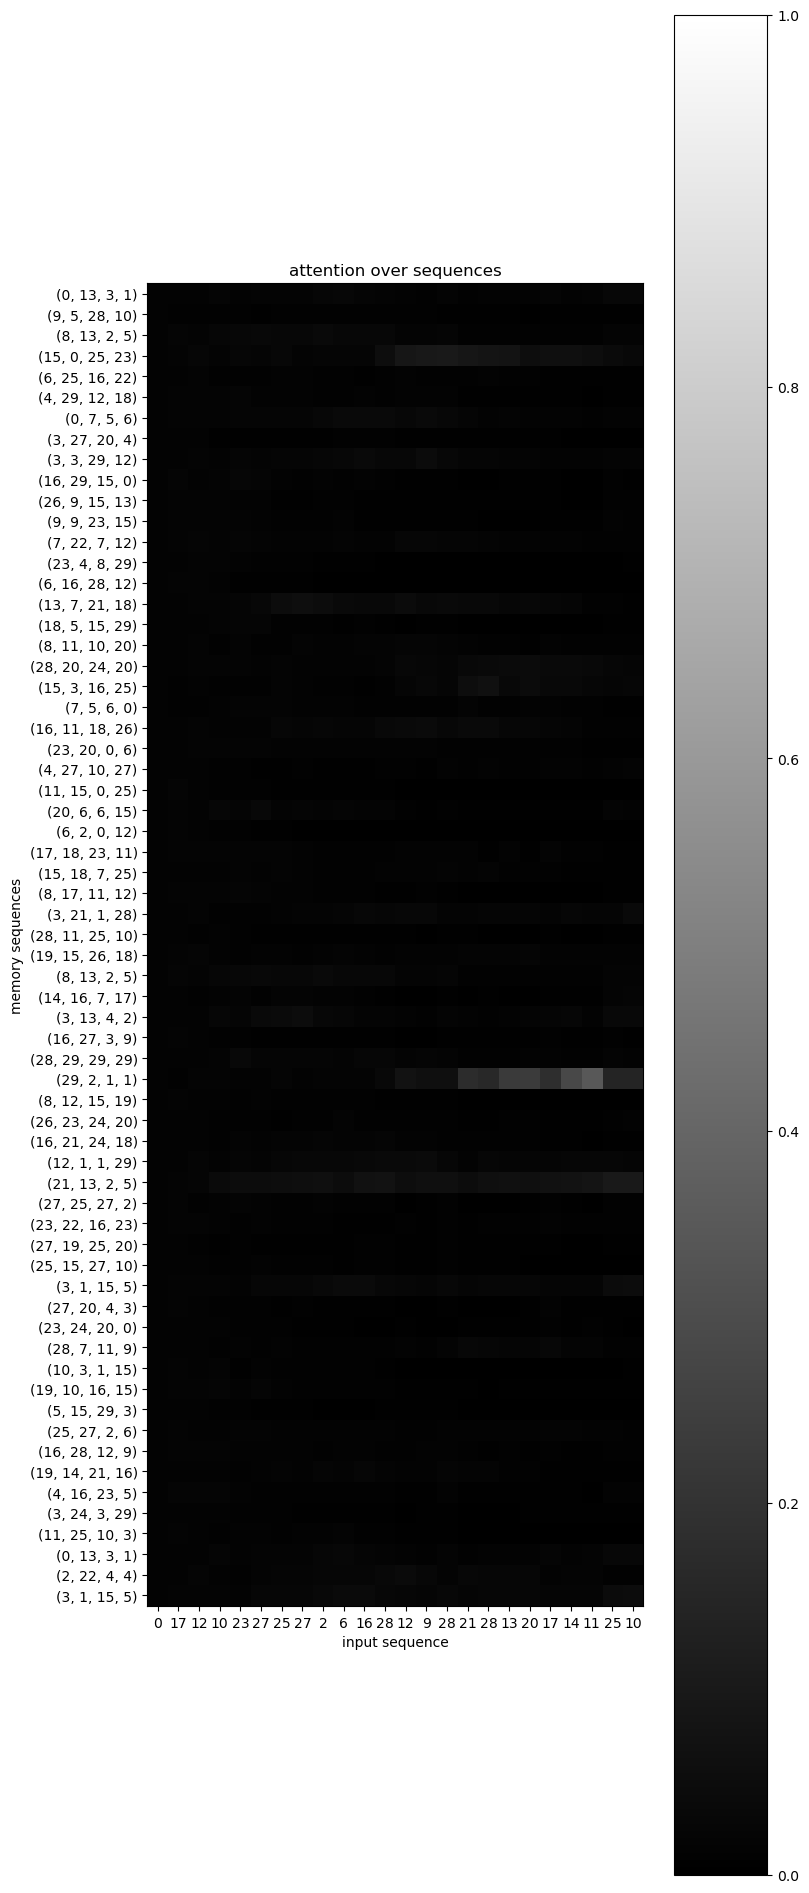

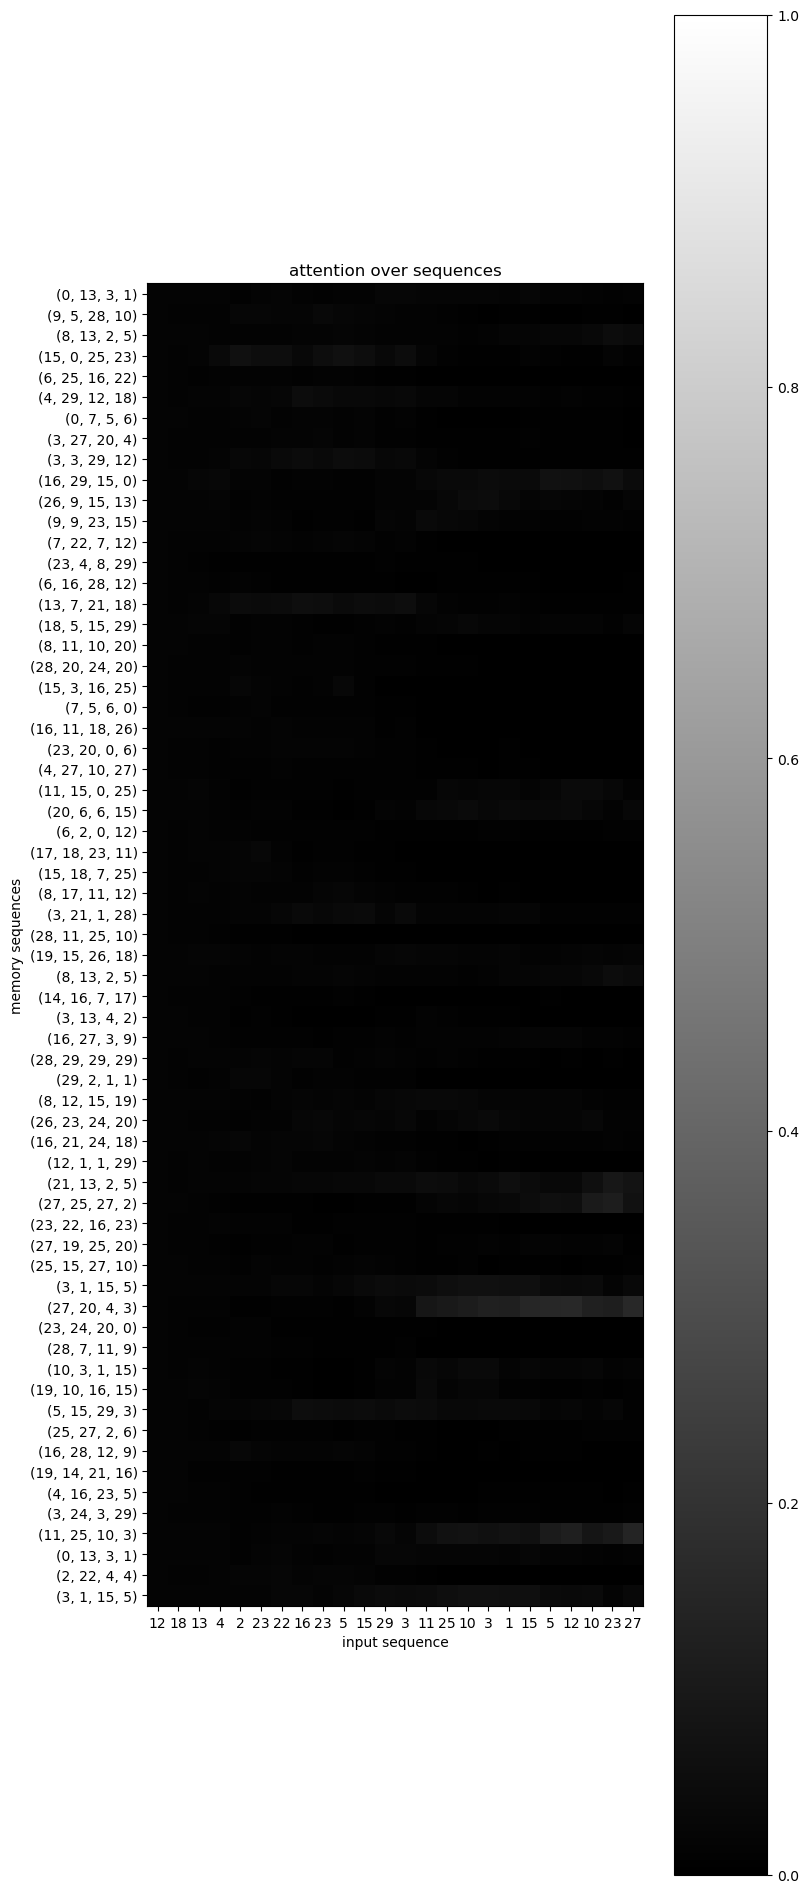

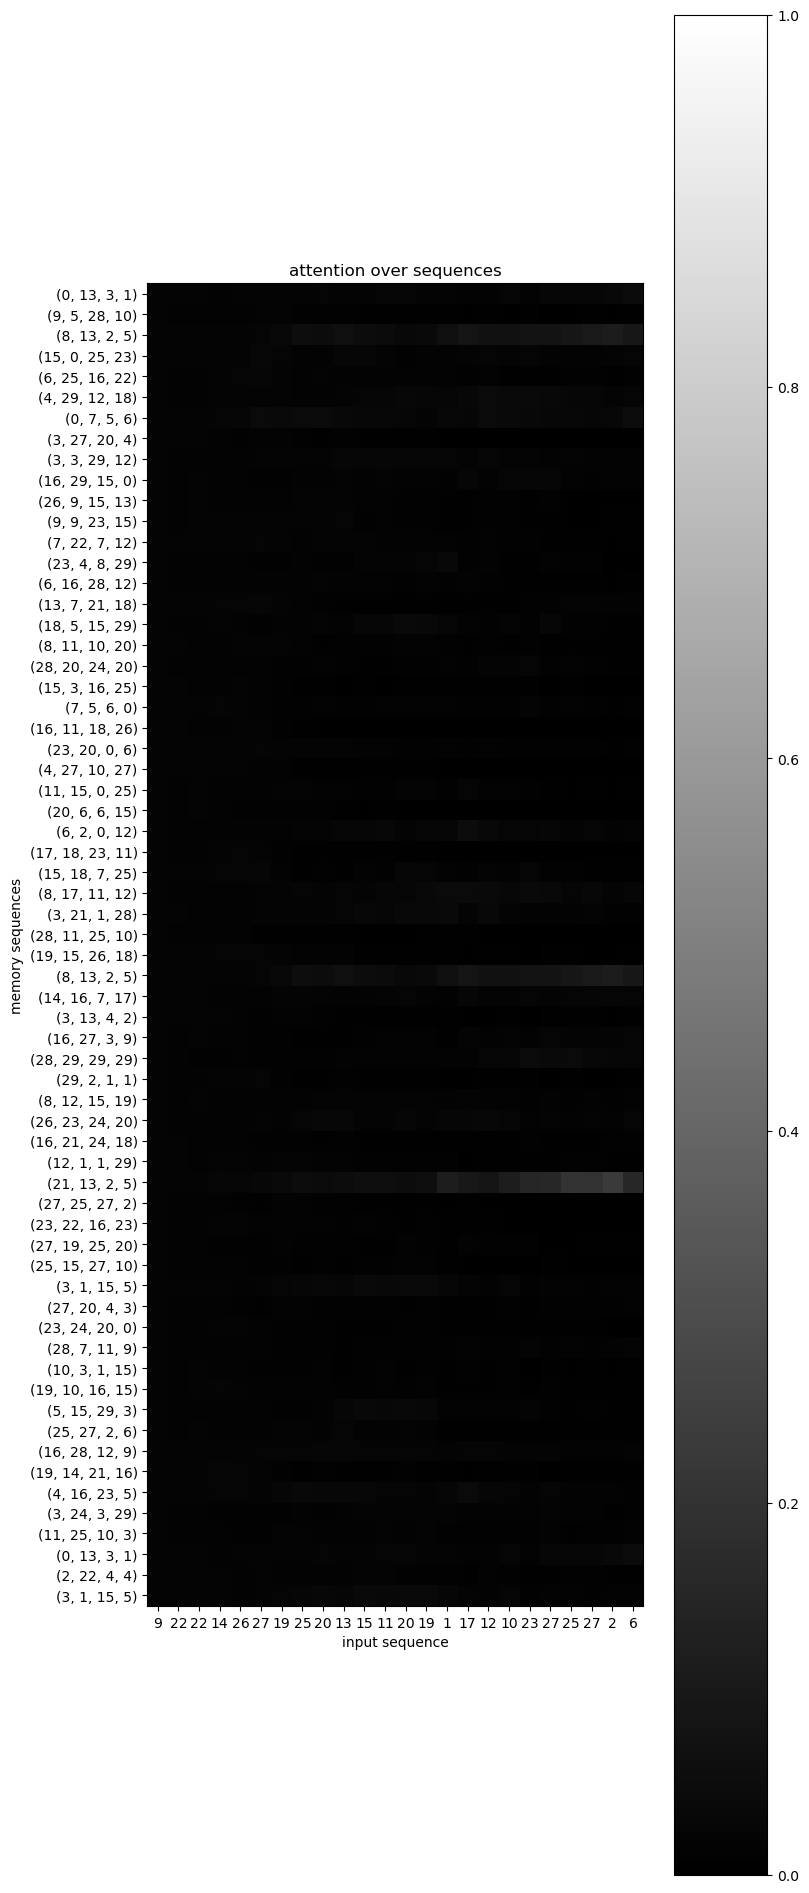

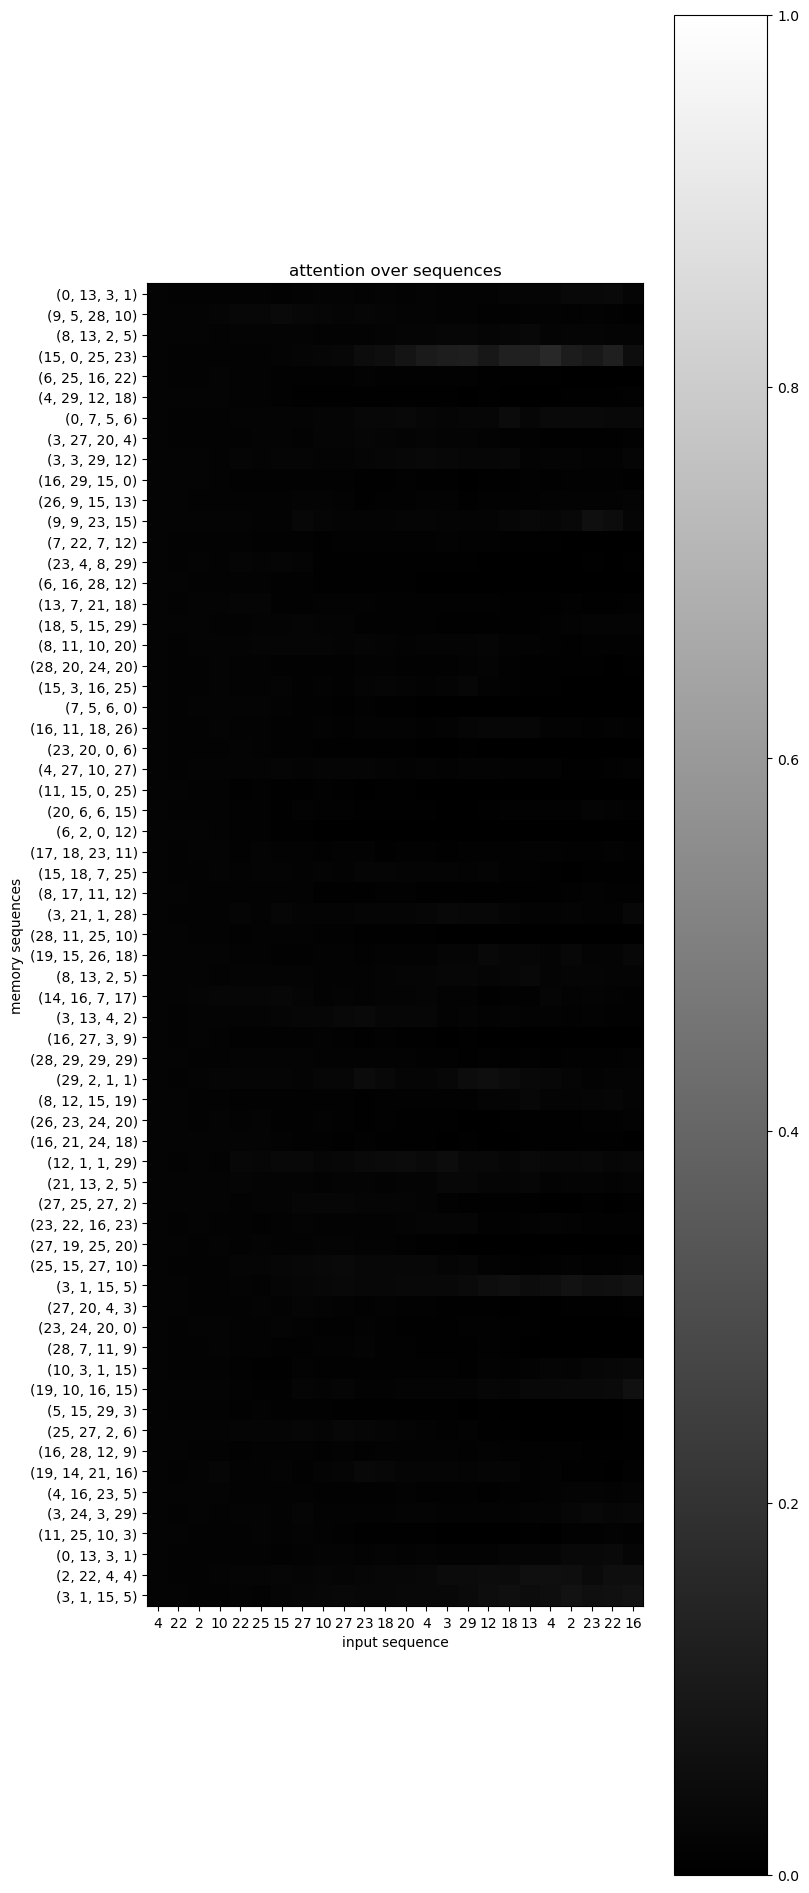

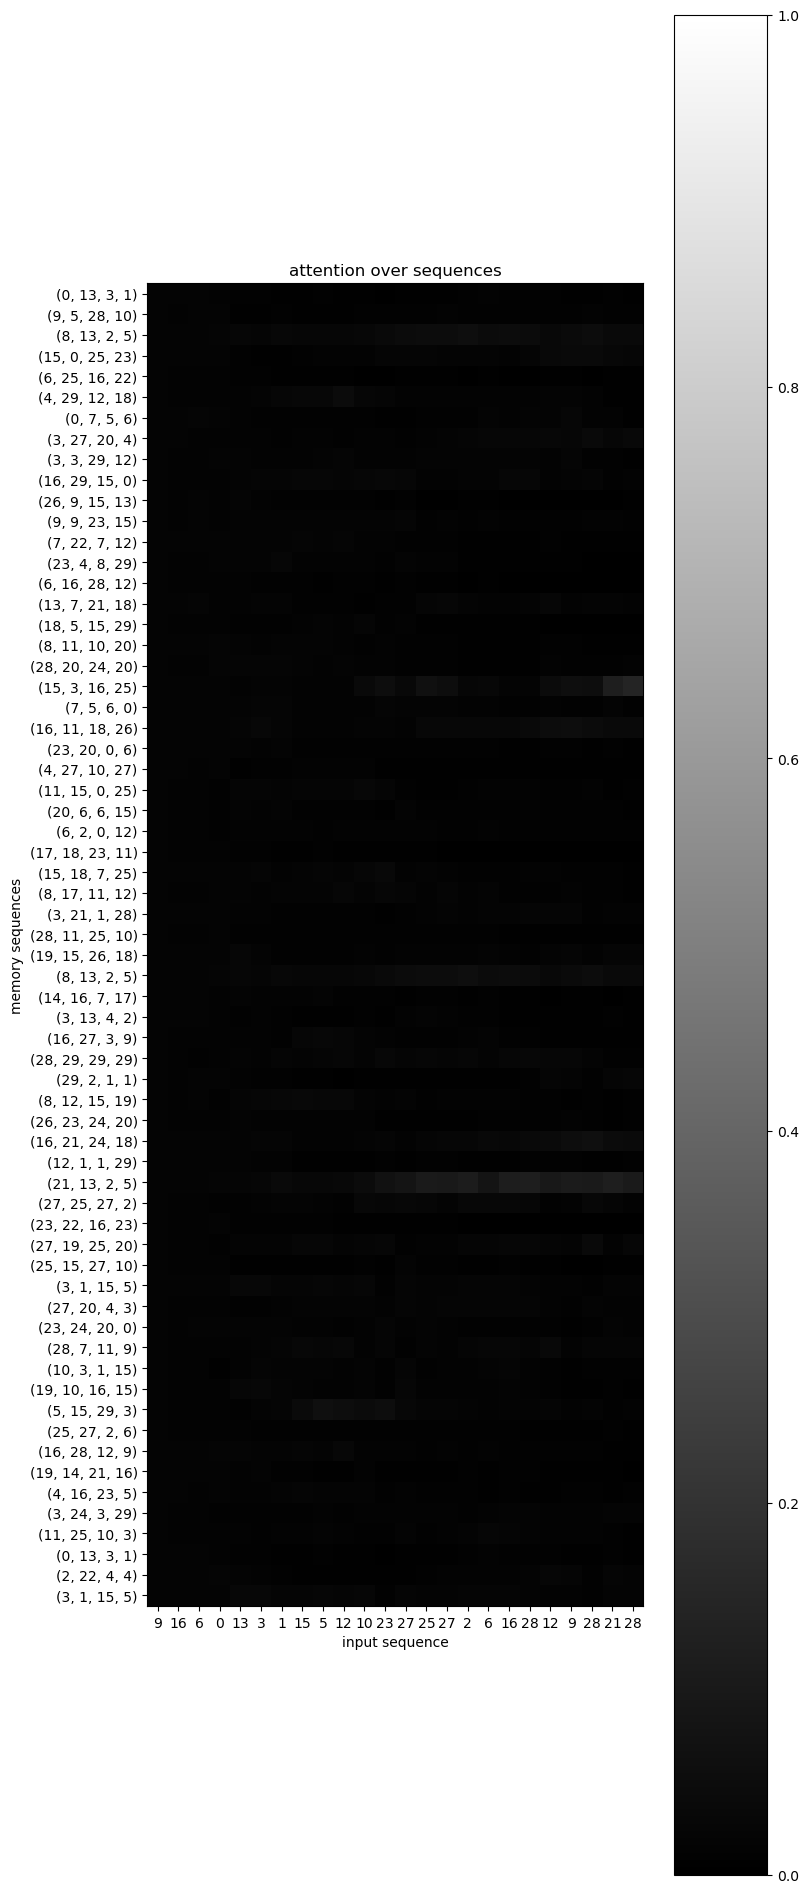

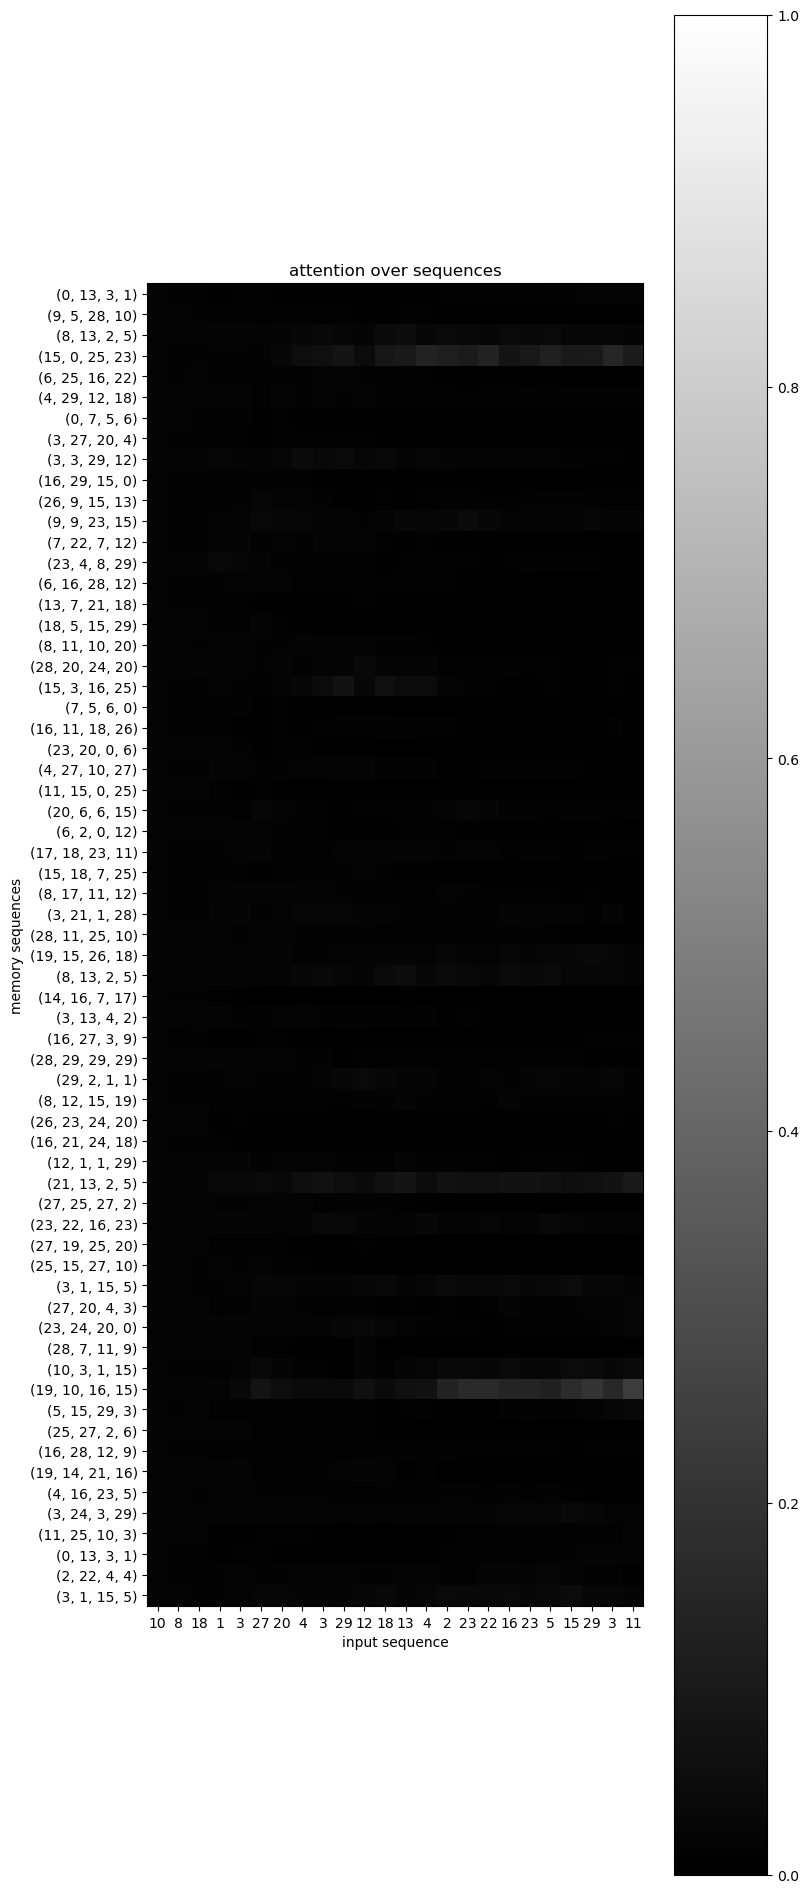

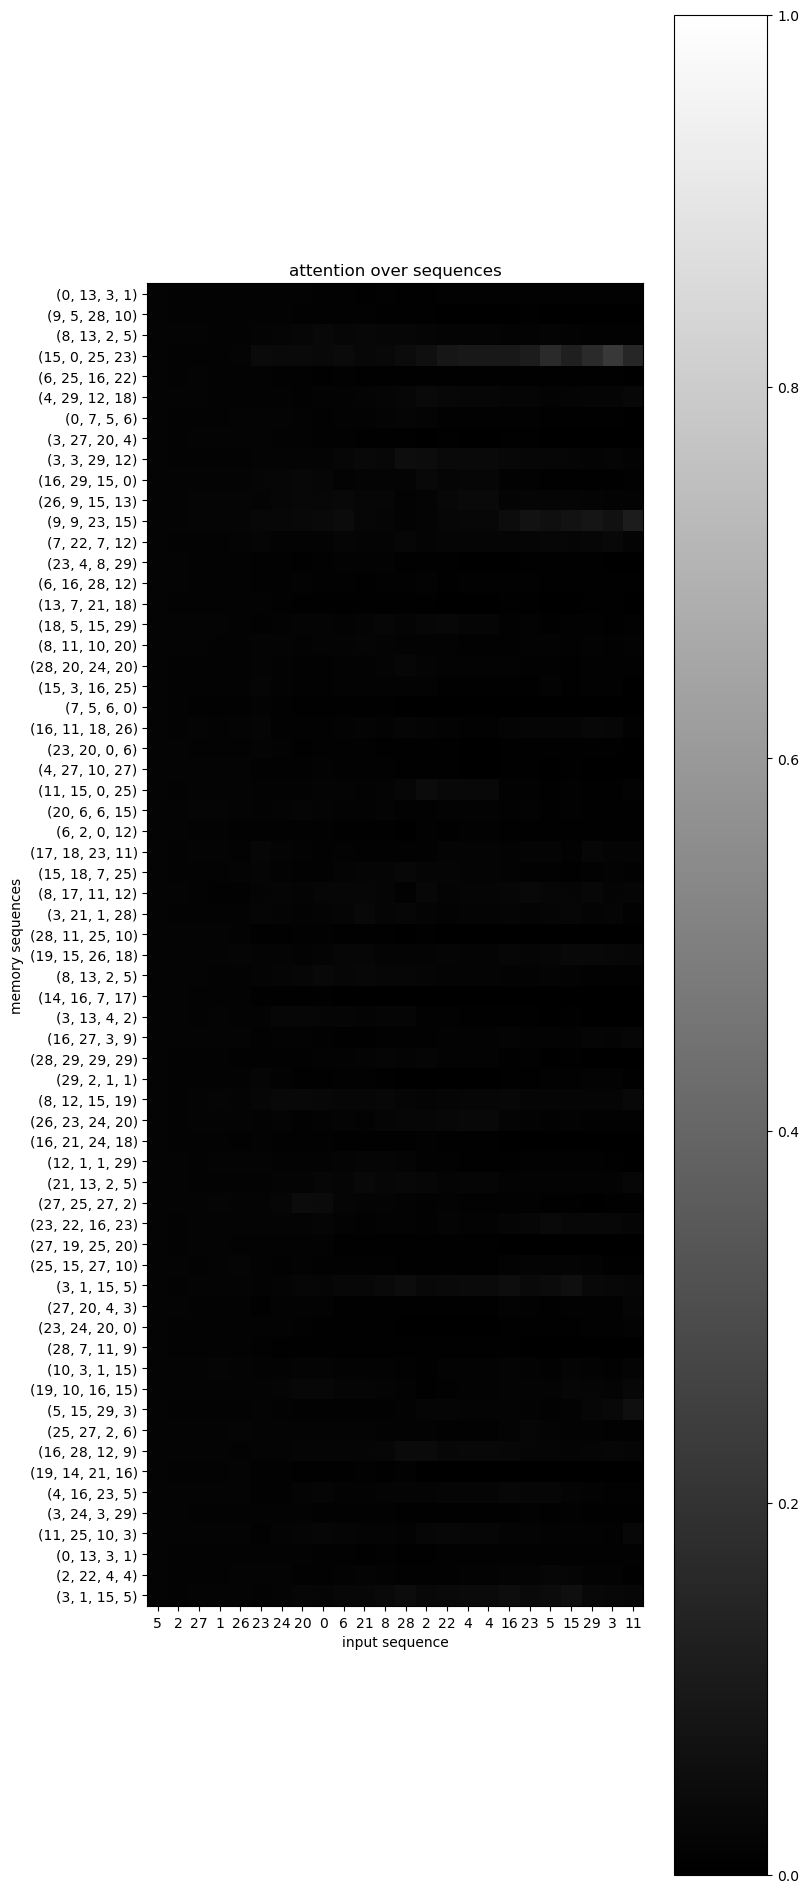

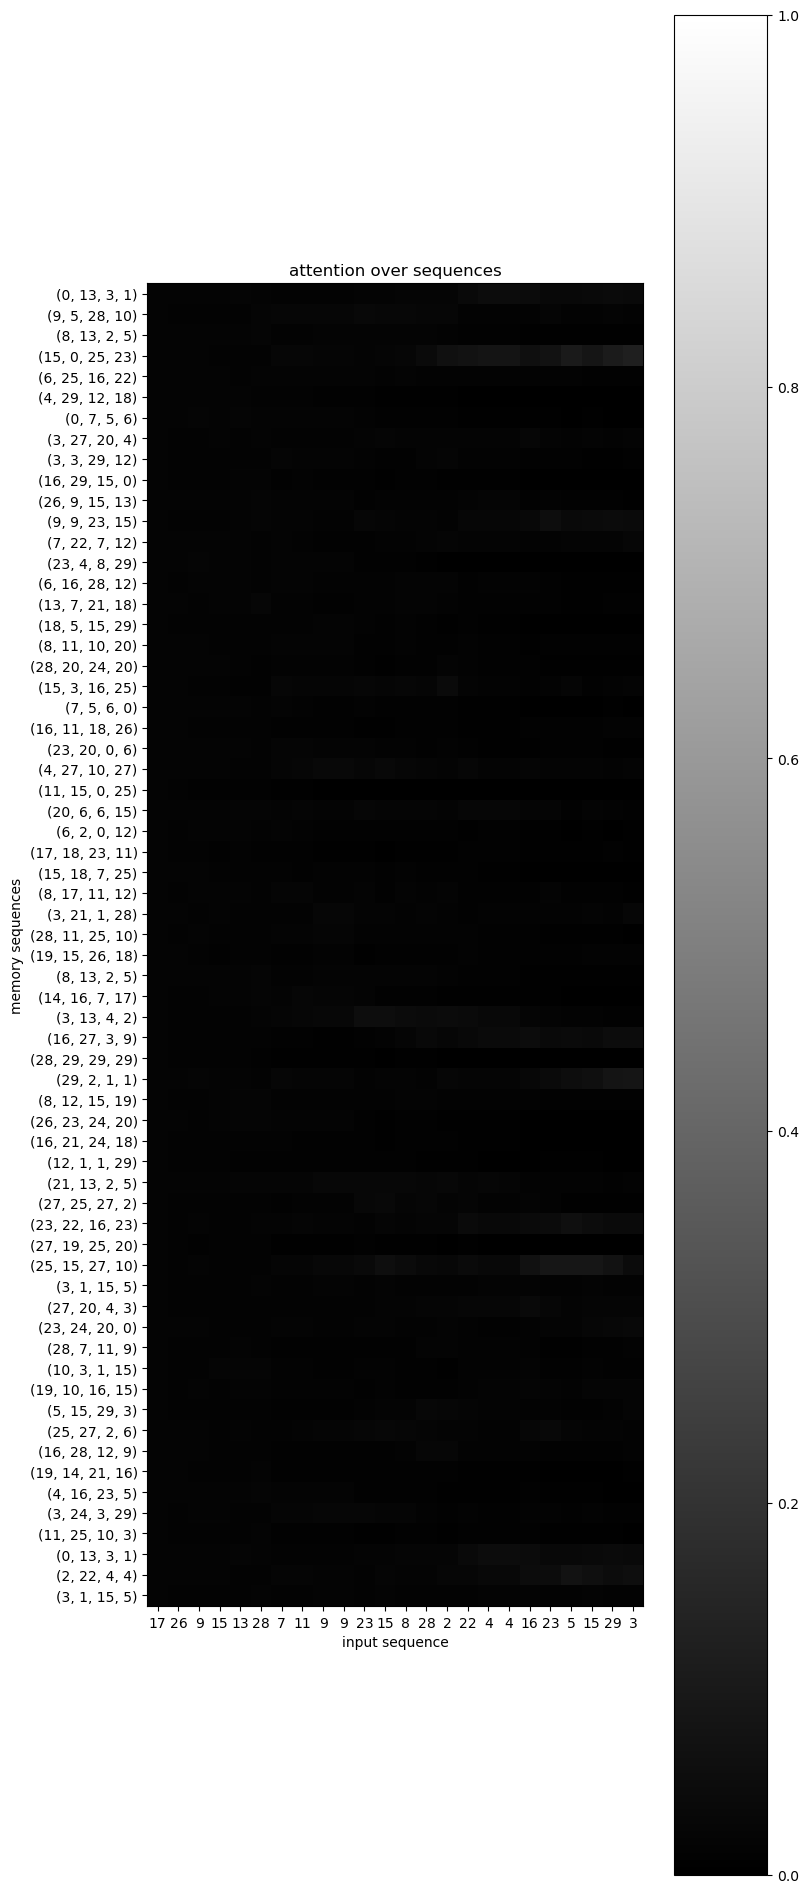

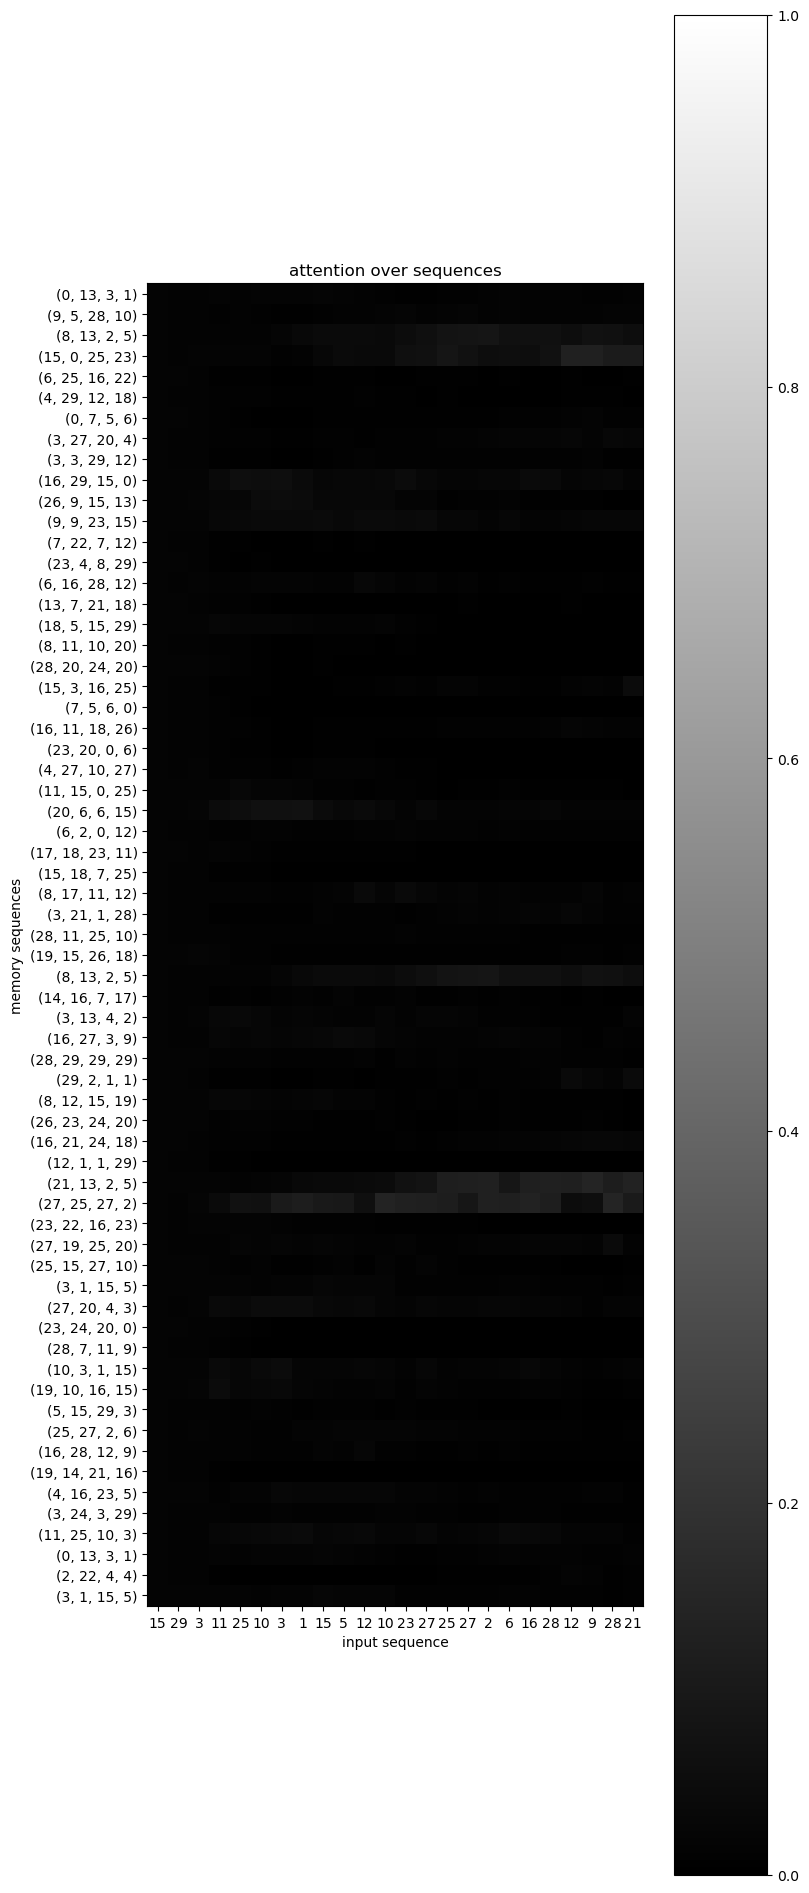

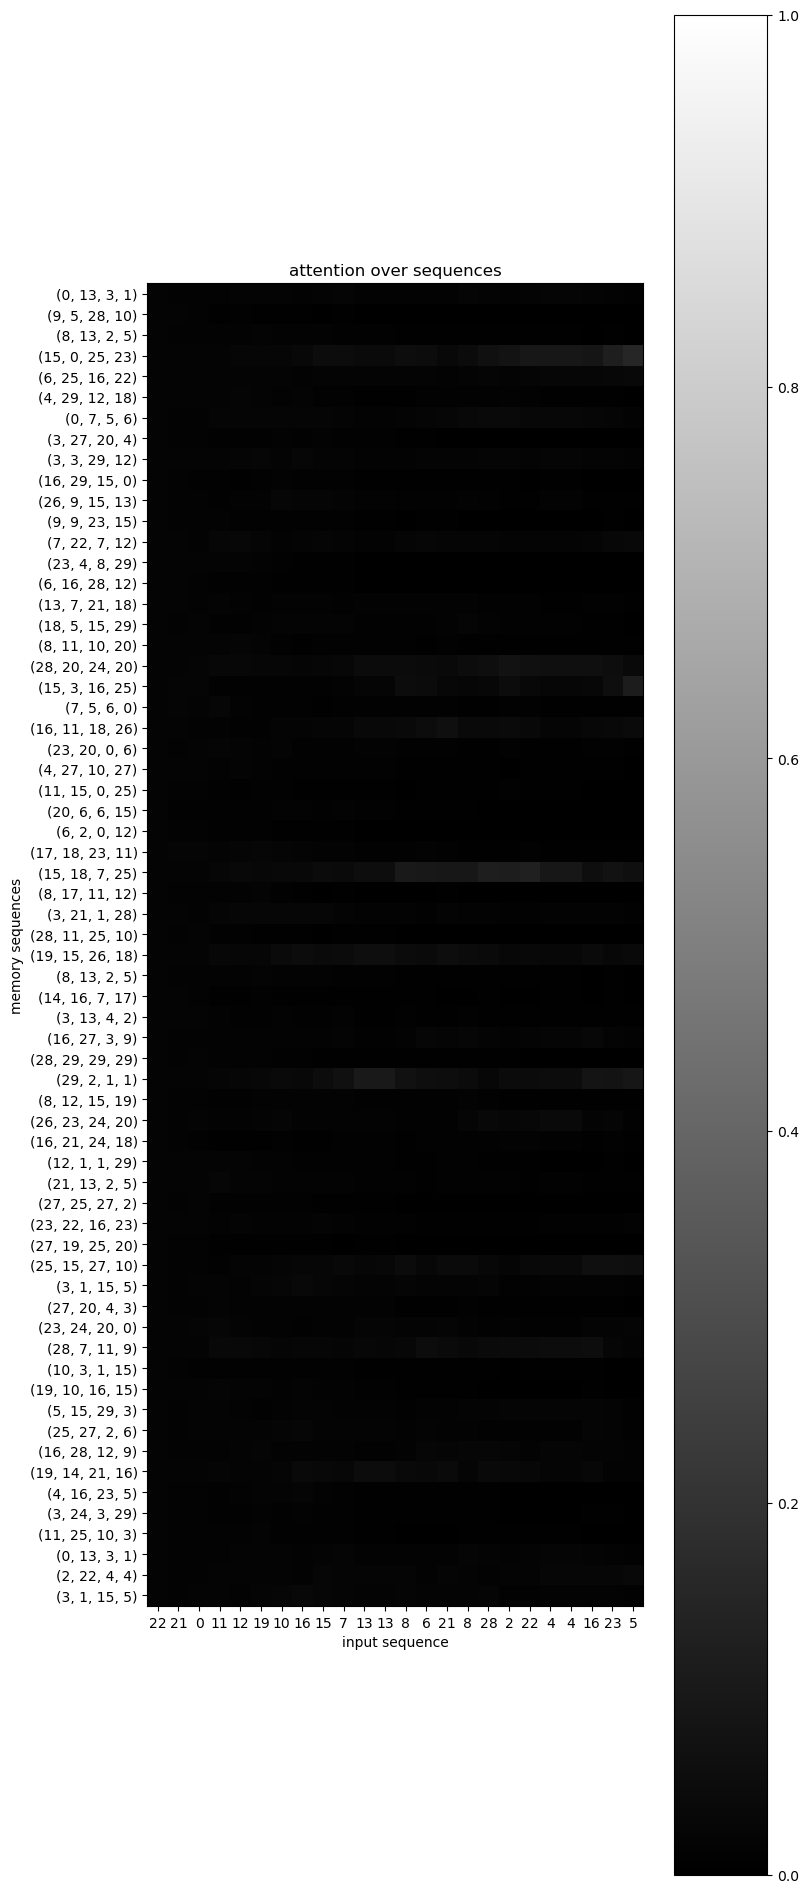

In [255]:
# training set
for i in range(n_train-15, n_train):
    plot_attention(i, seqs_x_train, seqs_y_train, mem_seqs_x_train, mem_seqs_y_train, memory_model1)


sample_input:  [[12  1  1 29 24 25 20 13 15 11 20 19  1 17 12 10 23 27 25 27  2  6 16 28]]
prediction: [11 10  3 24 25 20 13 15 11 20 19  1 17 12 10 23 27 25 27  2  6 16 28 12]
y: [ 1  1 29 24 25 20 13 15 11 20 19  1 17 12 10 23 27 25 27  2  6 16 28 12]
[False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[ 2  4 23  4  8 29 15  0 25 23  8 22 10  1  8  8  8  8  8  8  8  8  8  8]]
prediction: [27 10  4  0 29 15  0 25 23  8 22 10  1  8  8  8  8  8  8  8  8  8  8  8]
y: [ 4 23  4  8 29 15  0 25 23  8 22 10  1  8  8  8  8  8  8  8  8  8  8  8]
[False False  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[ 5 21  3  2 27  1 26 23 24 20  0  6 21  8 28  2 22  4  4 16 23  5 15 29]]
prediction: [ 2  0 20 27  5 26 23 24 20  0  6 21  8 28  2 22  4  4 16 23  5 15 29  3]
y: [21  3  2 27  1 26

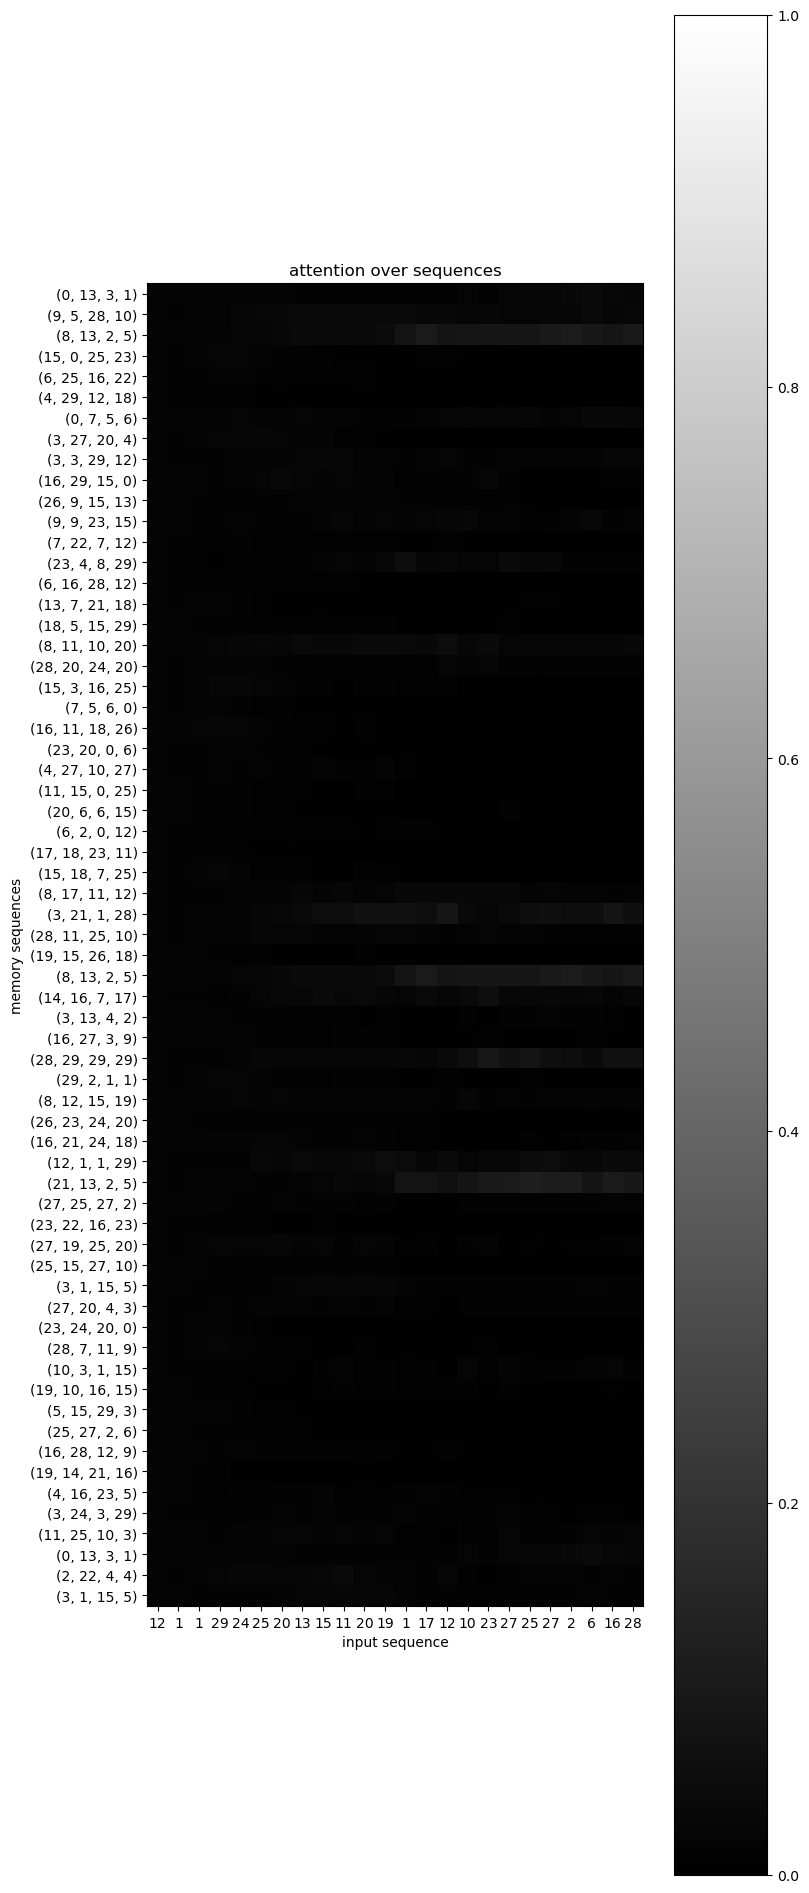

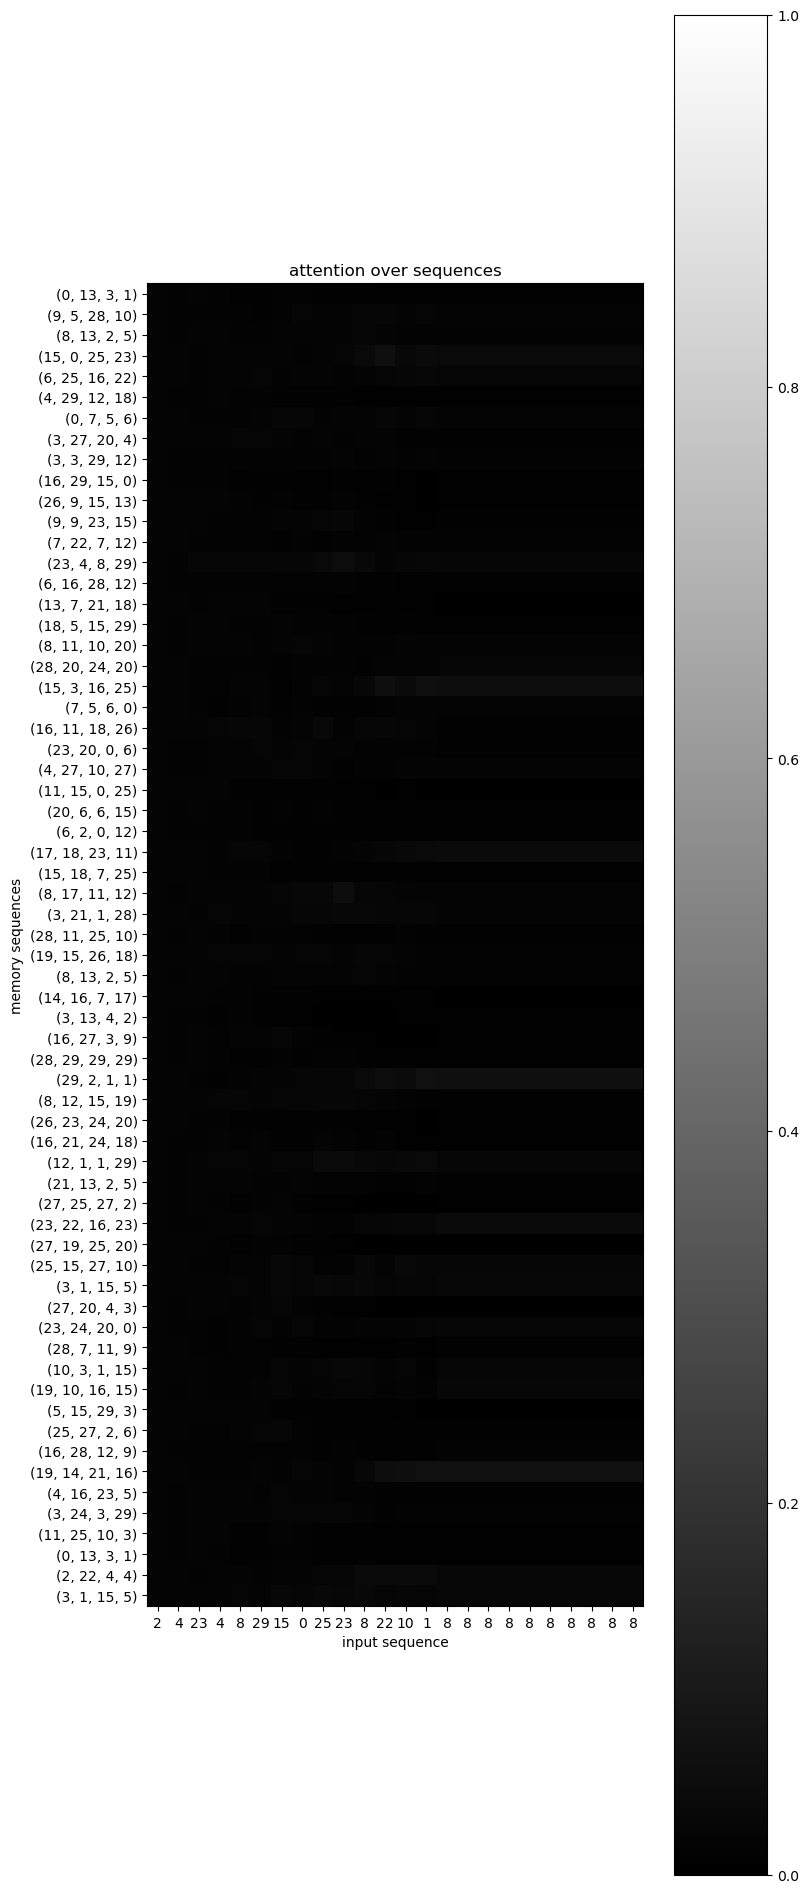

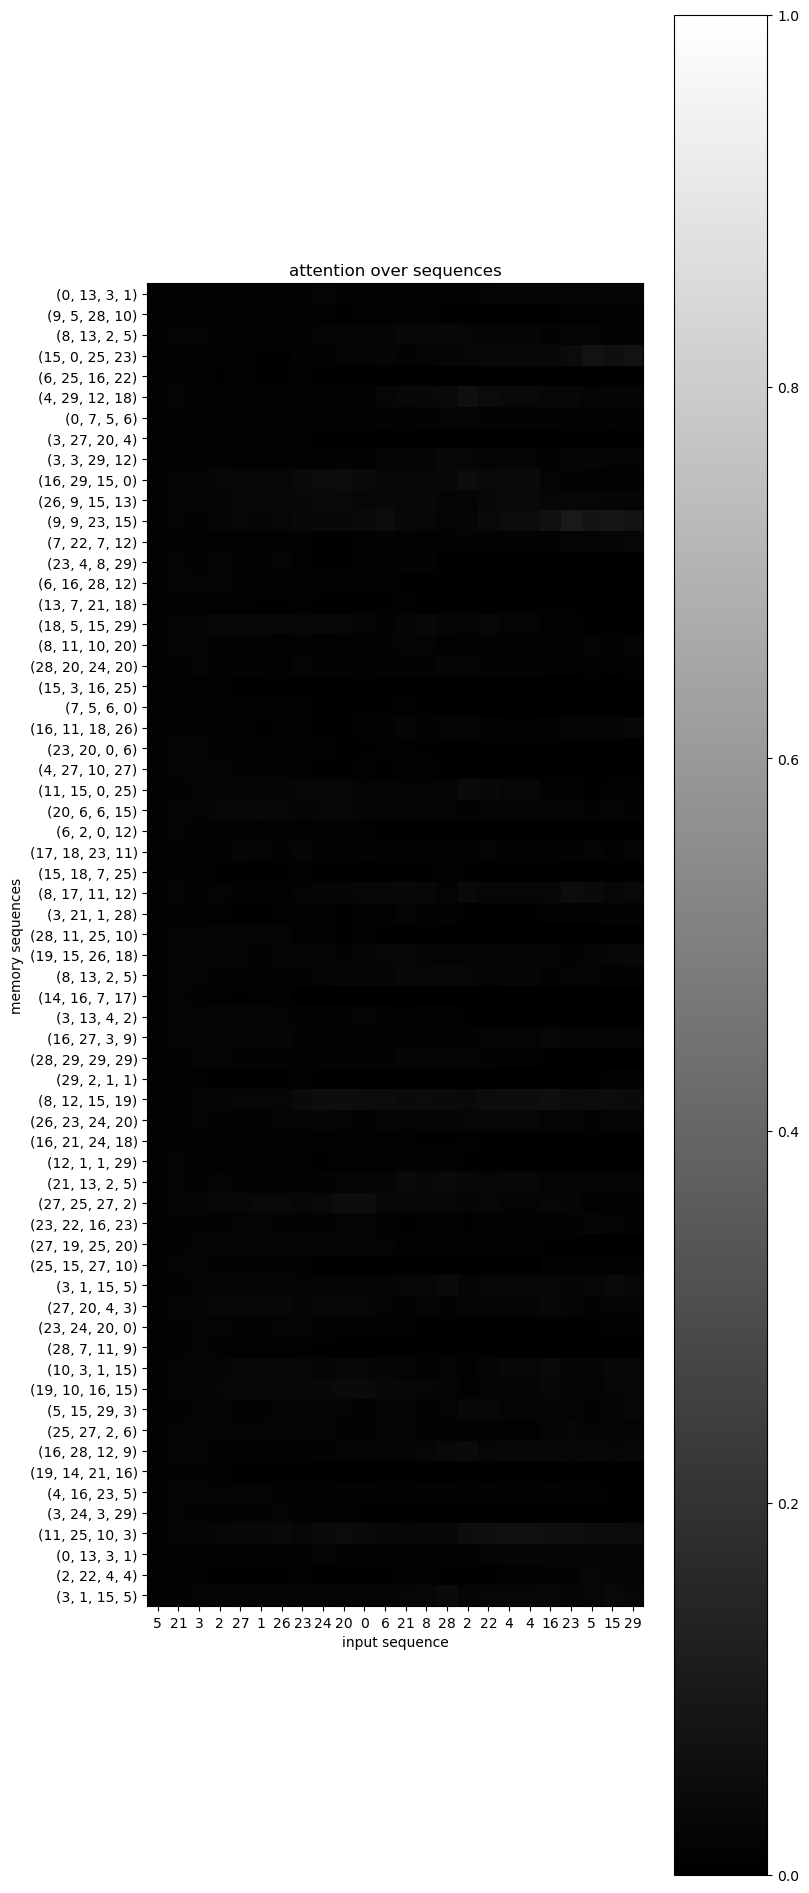

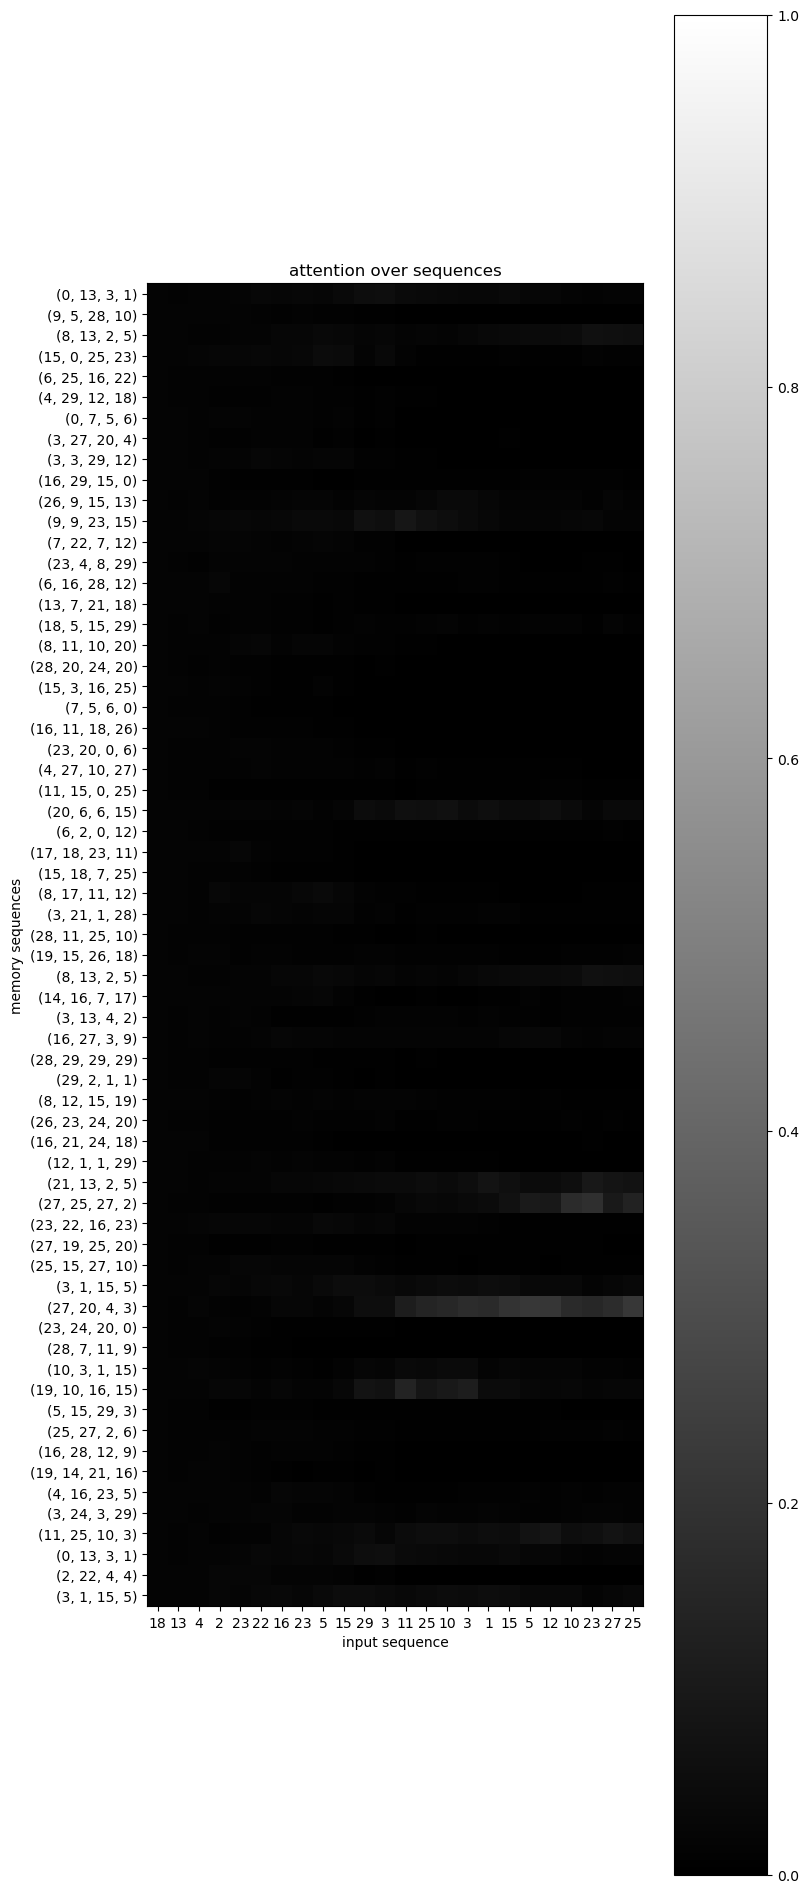

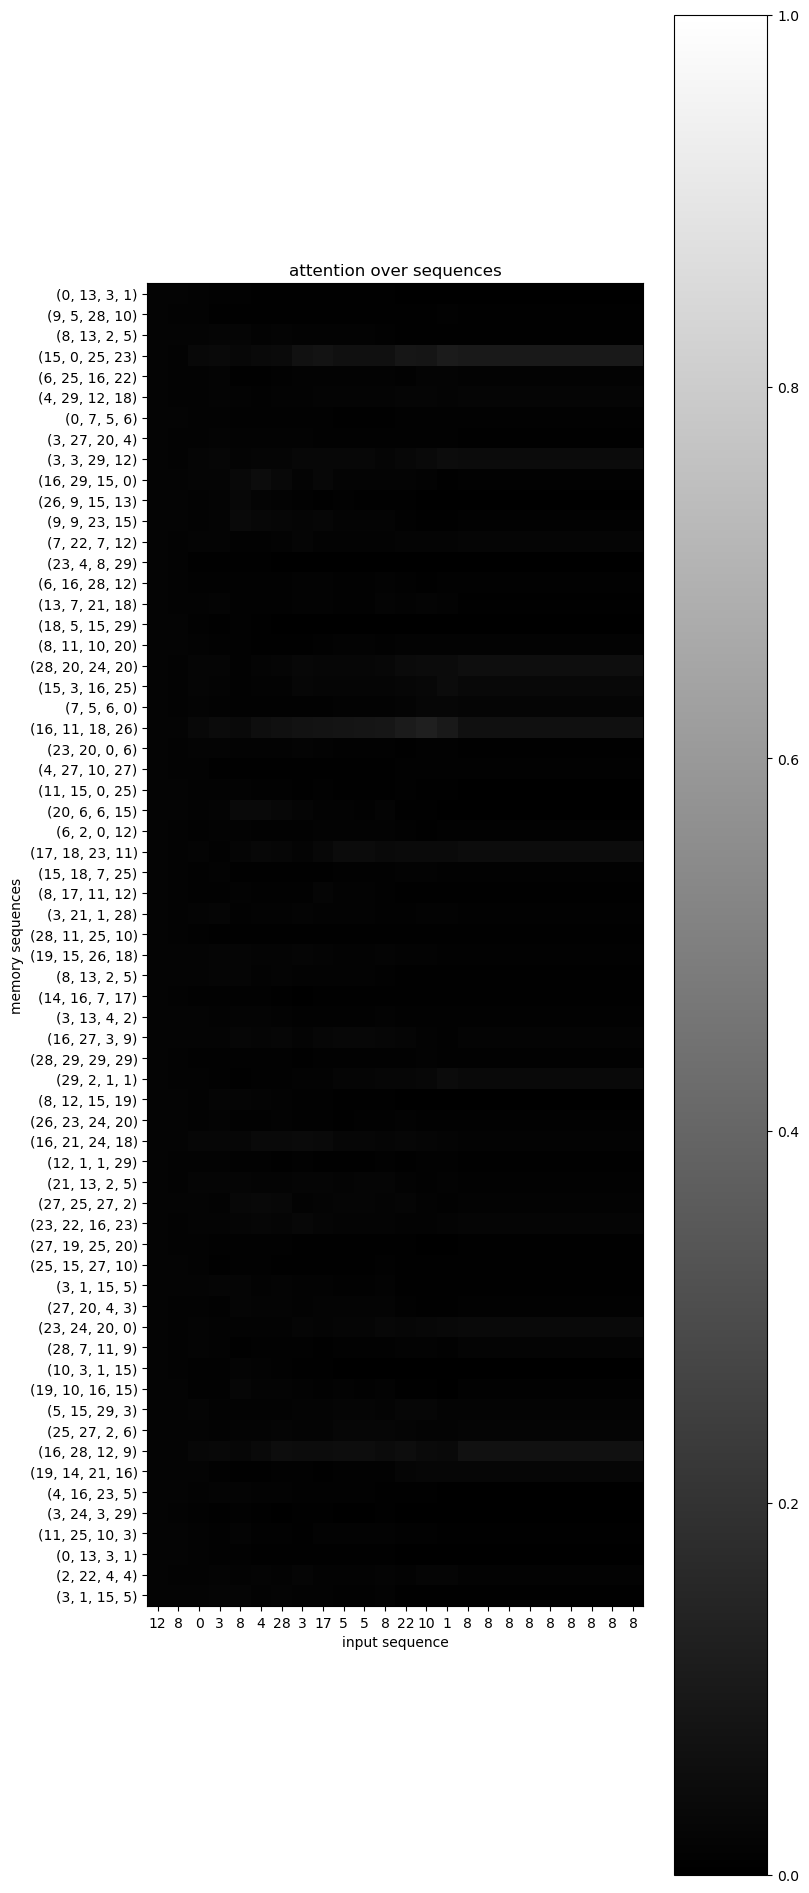

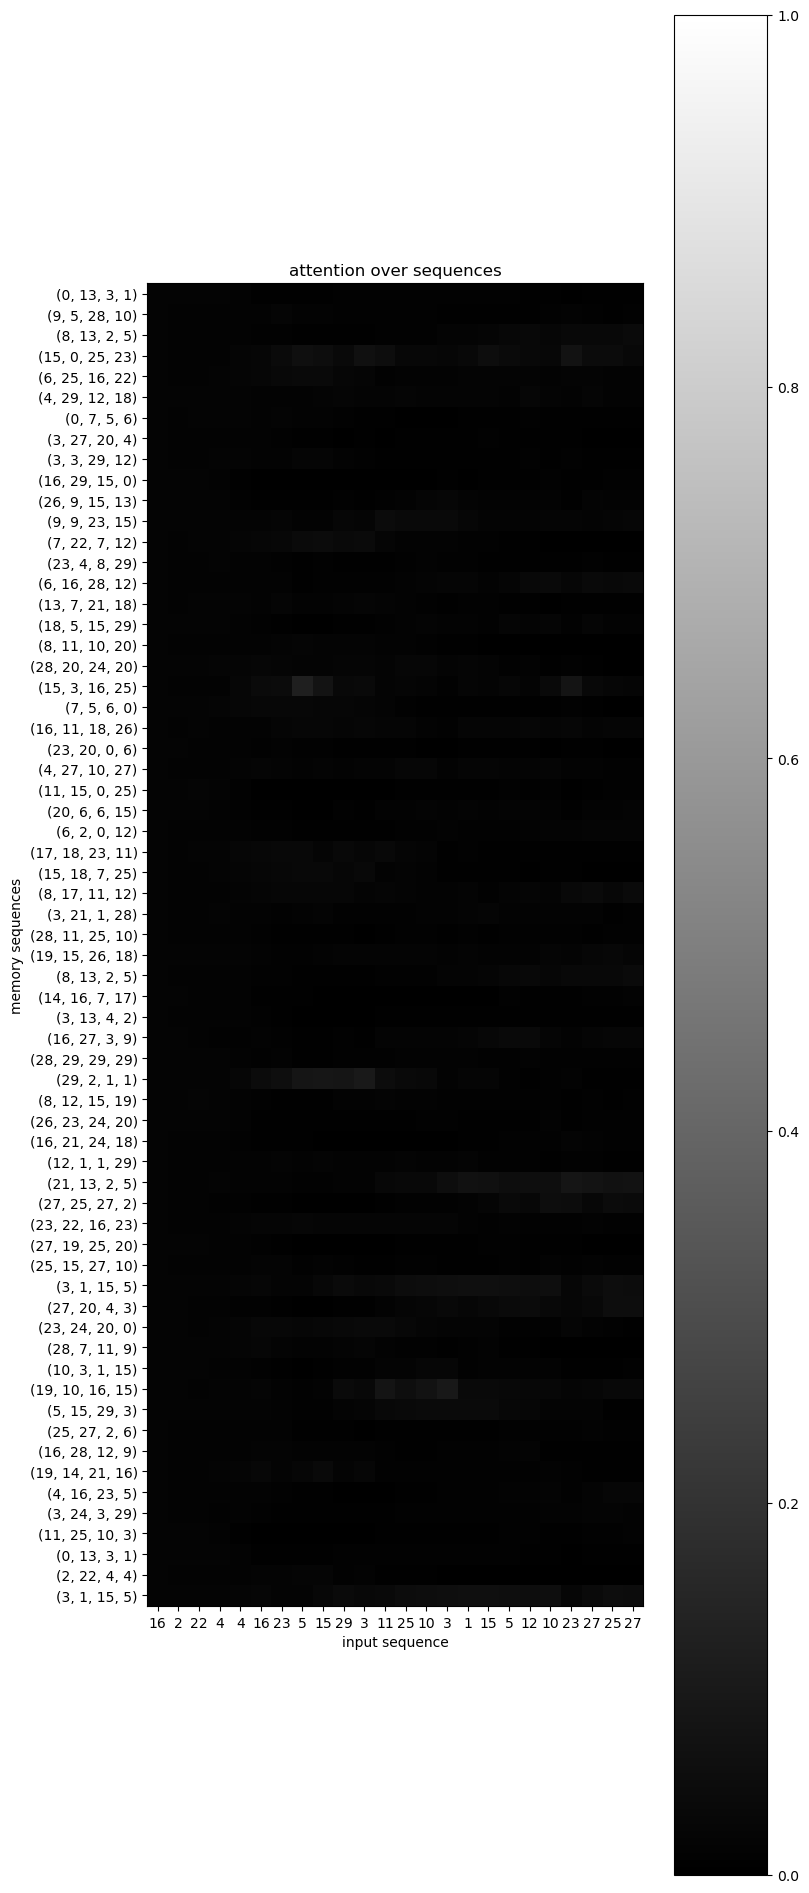

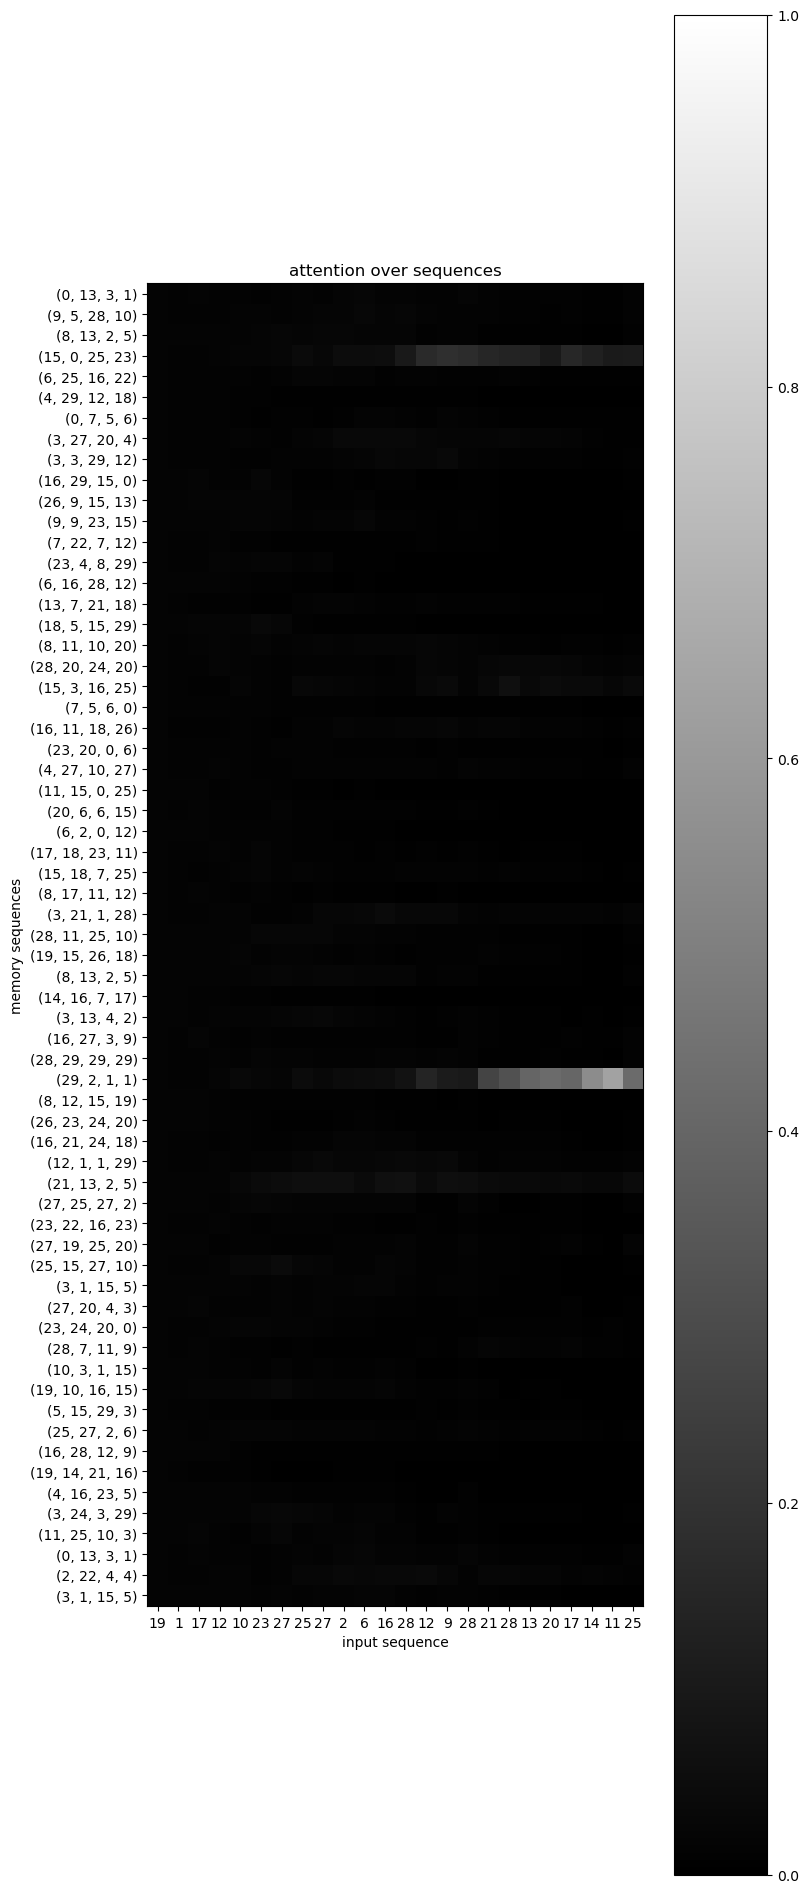

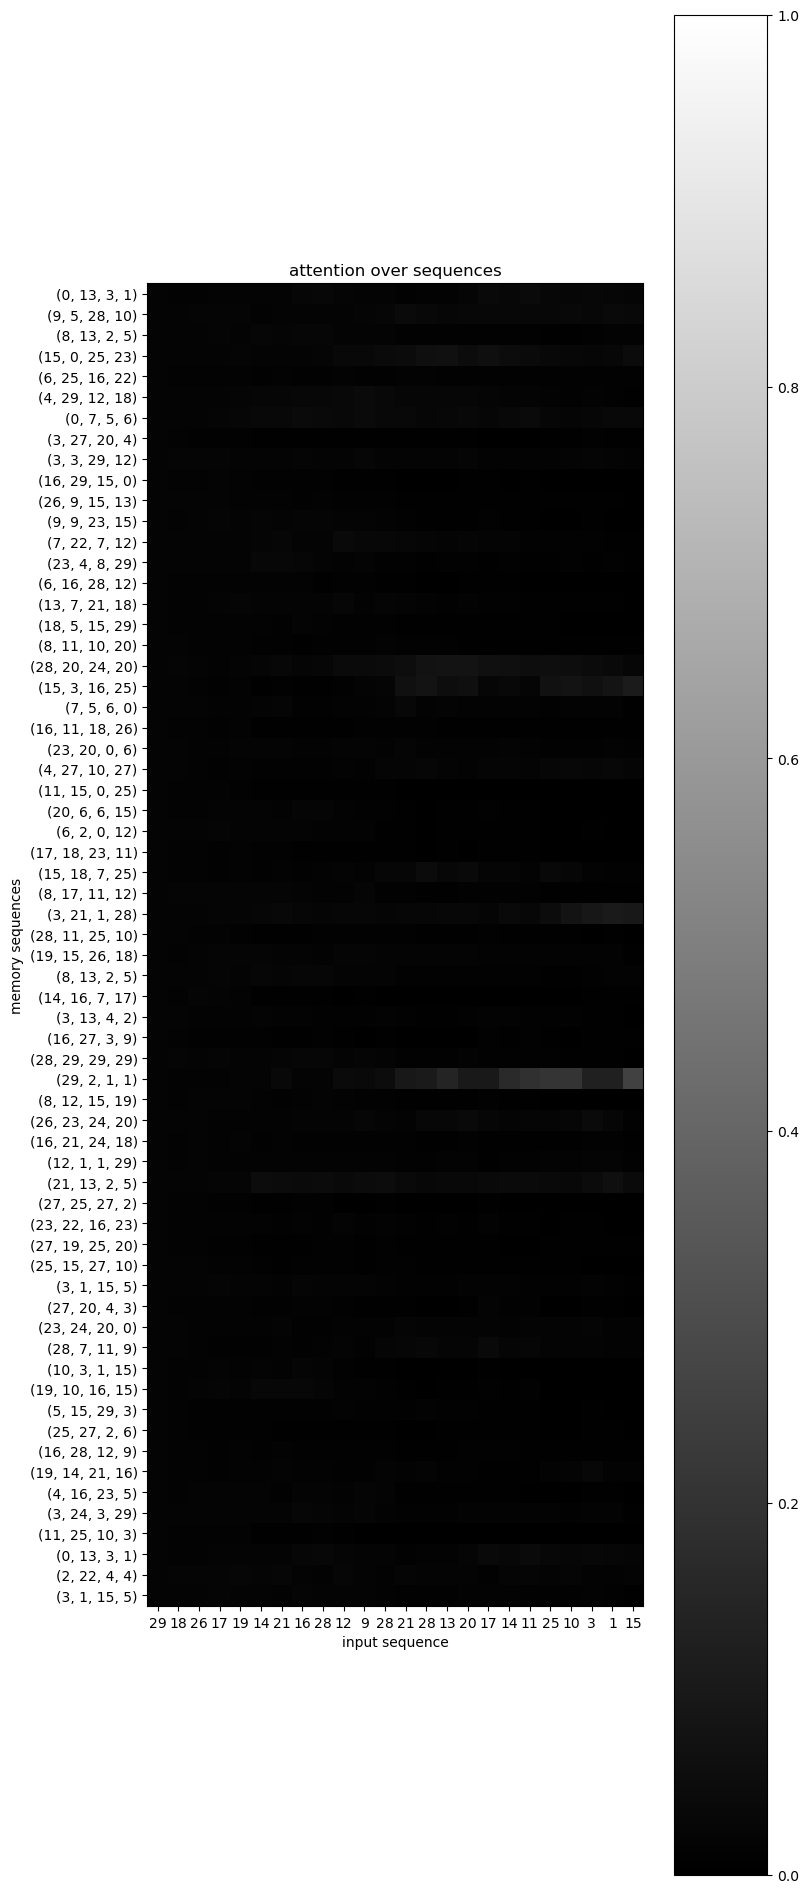

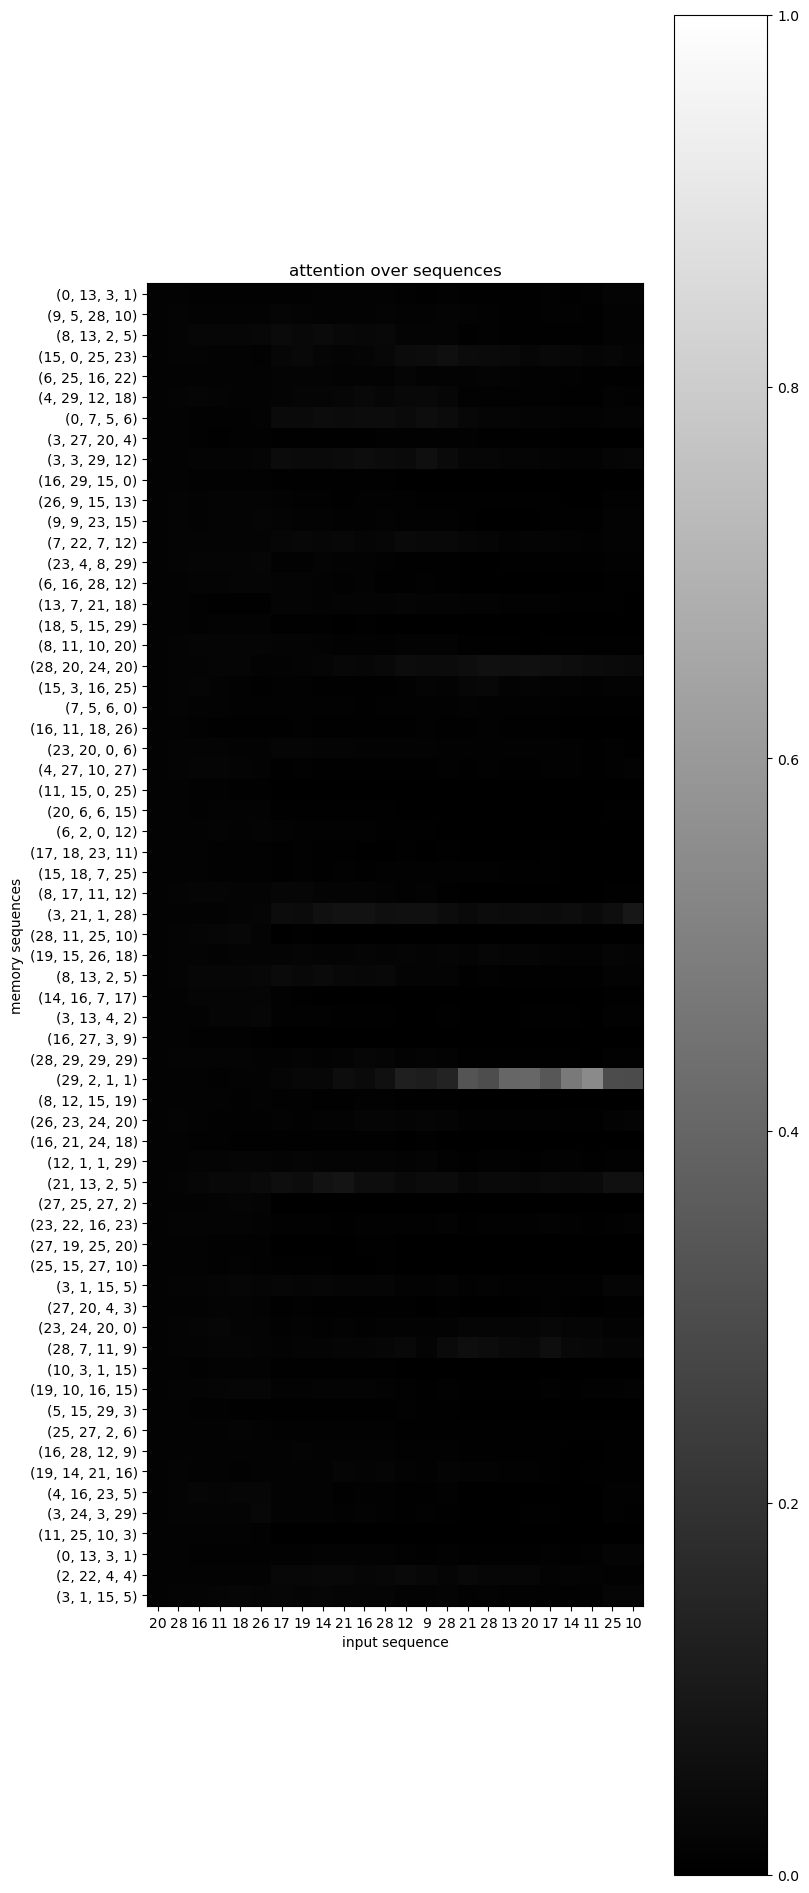

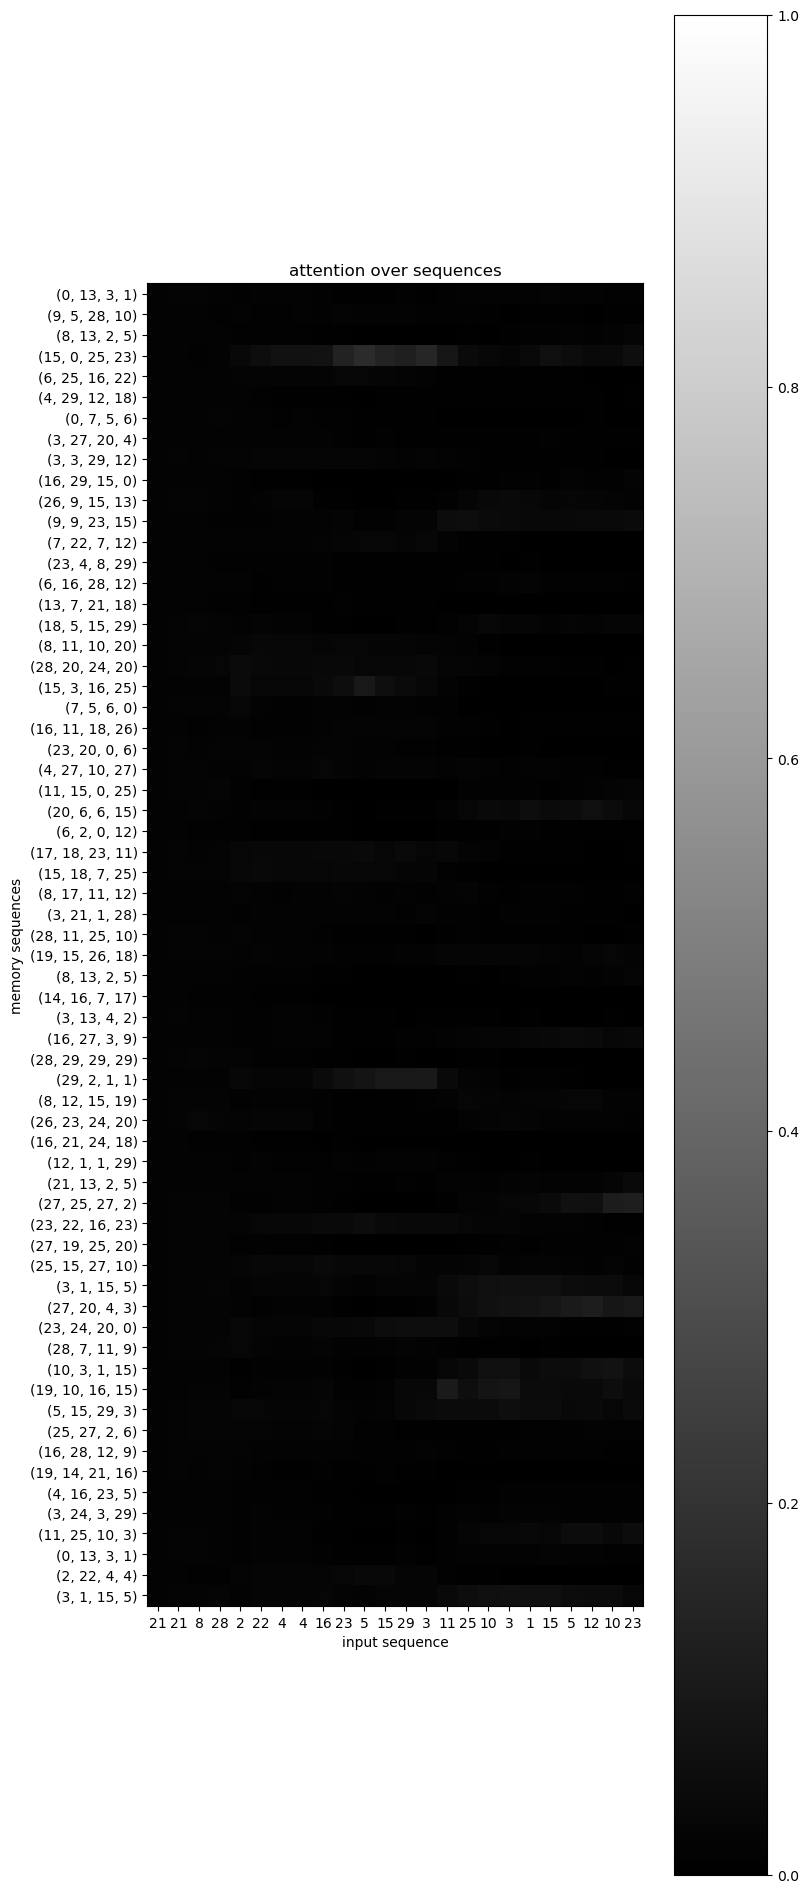

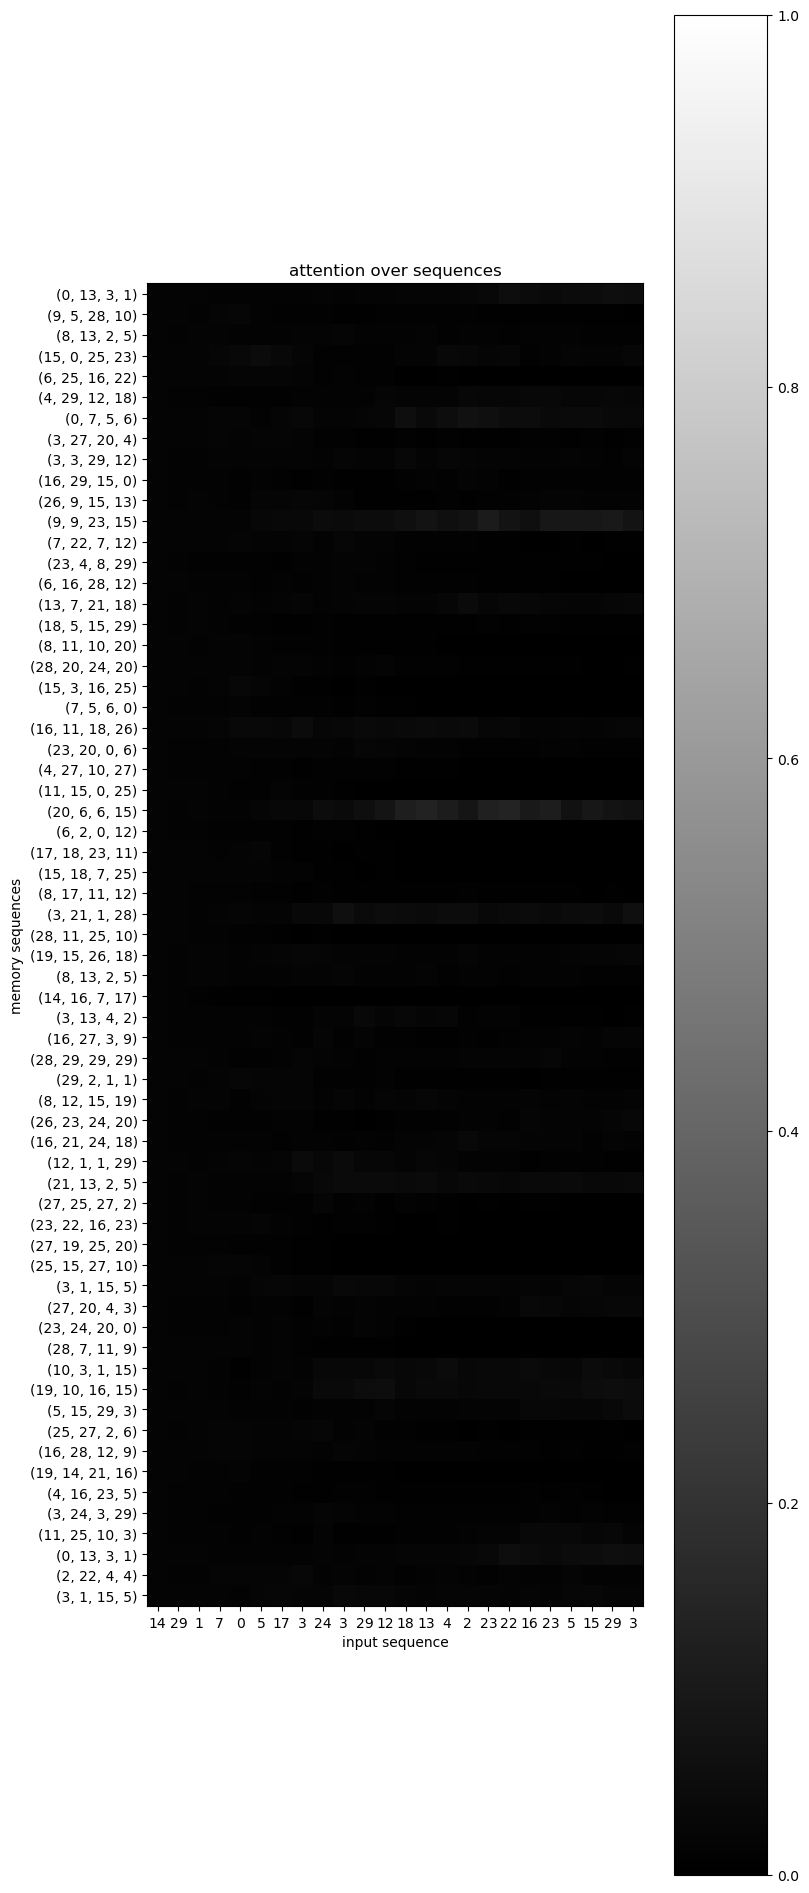

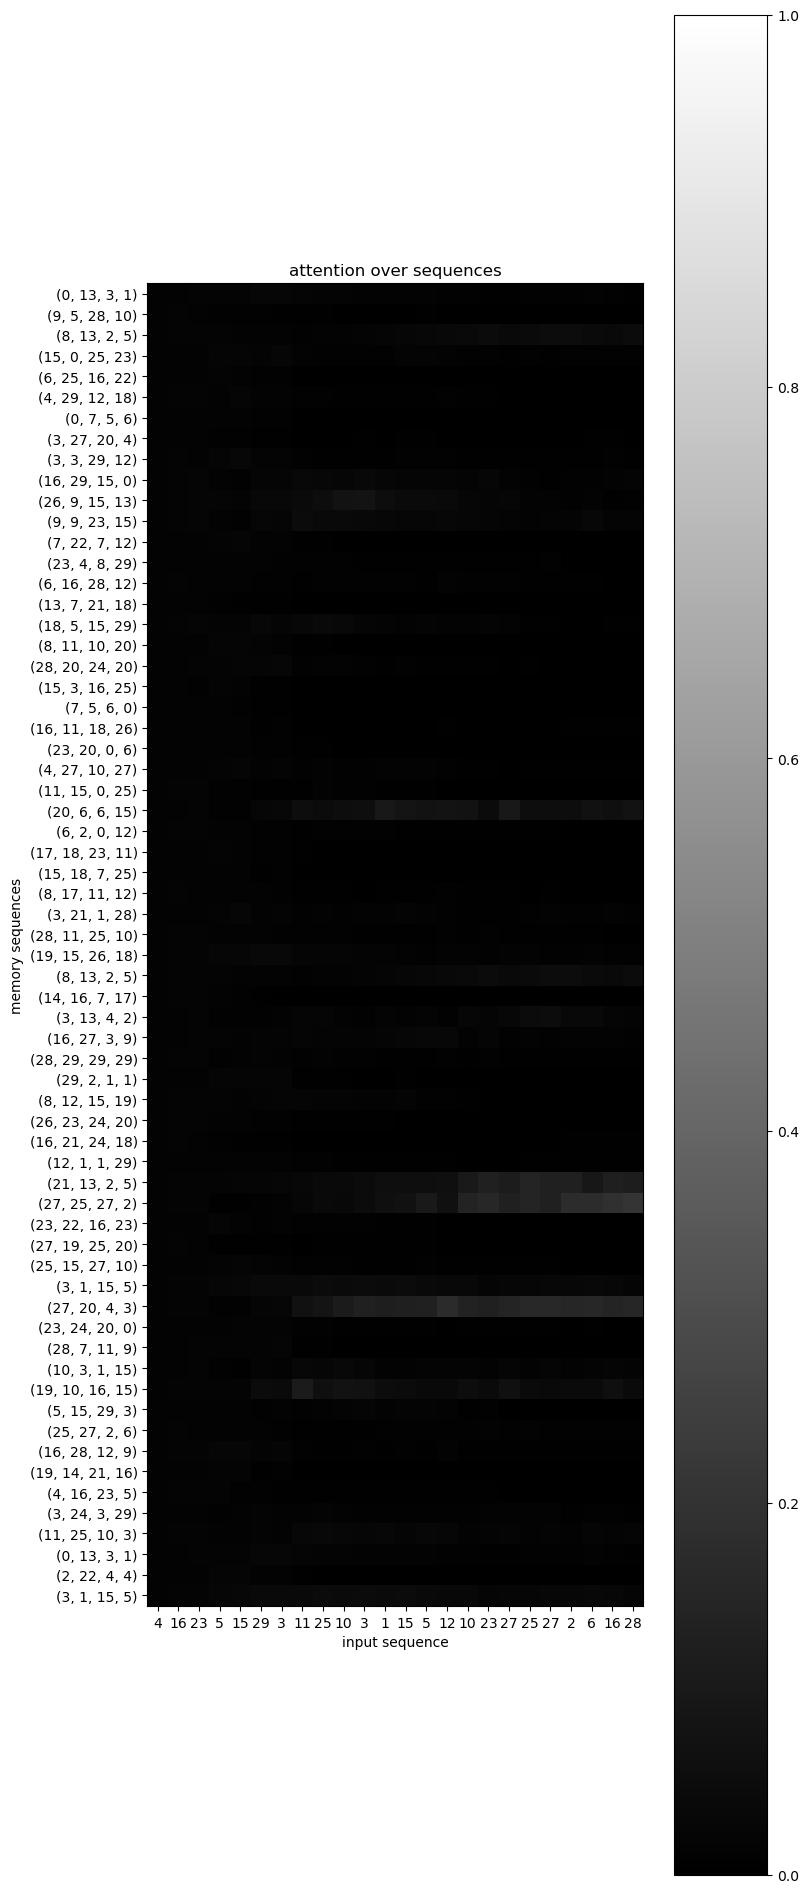

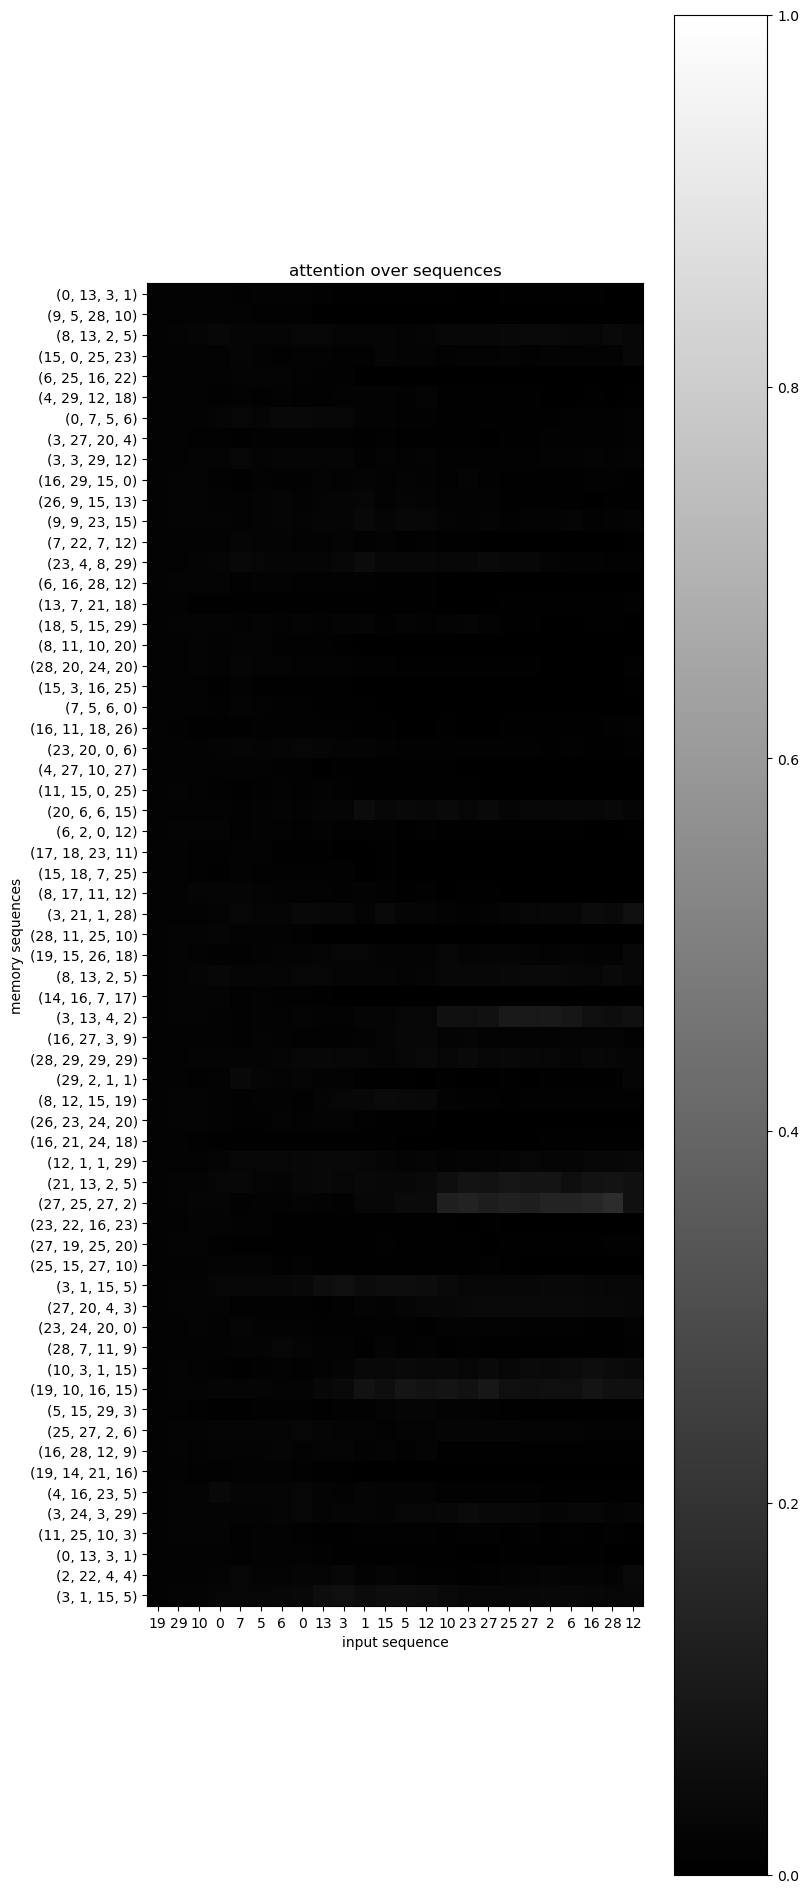

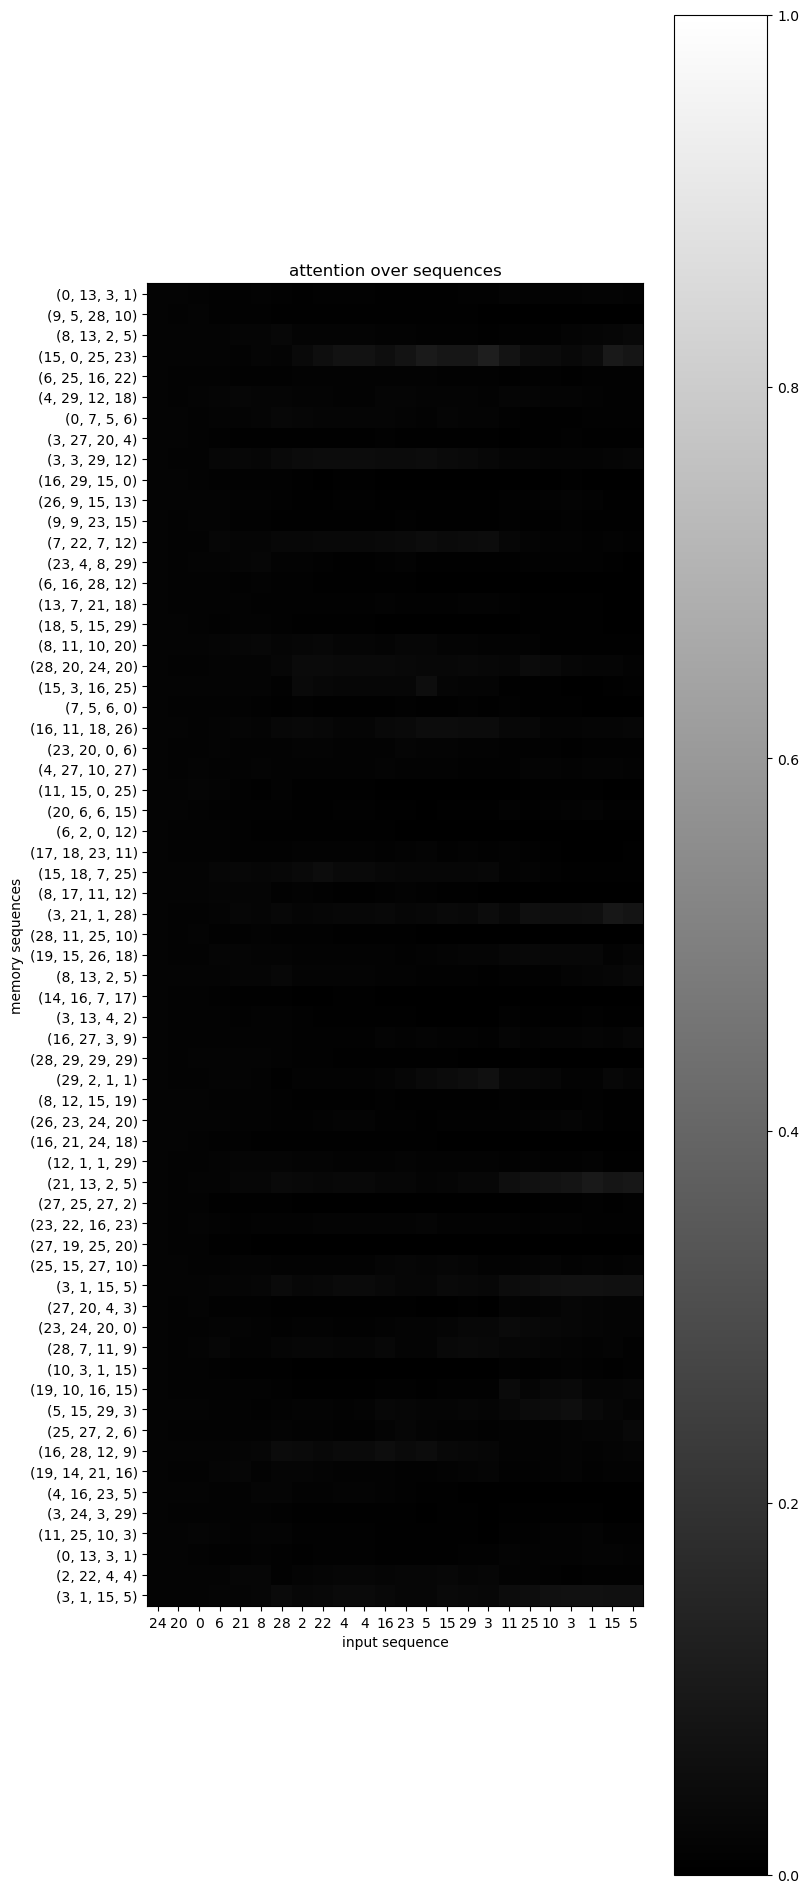

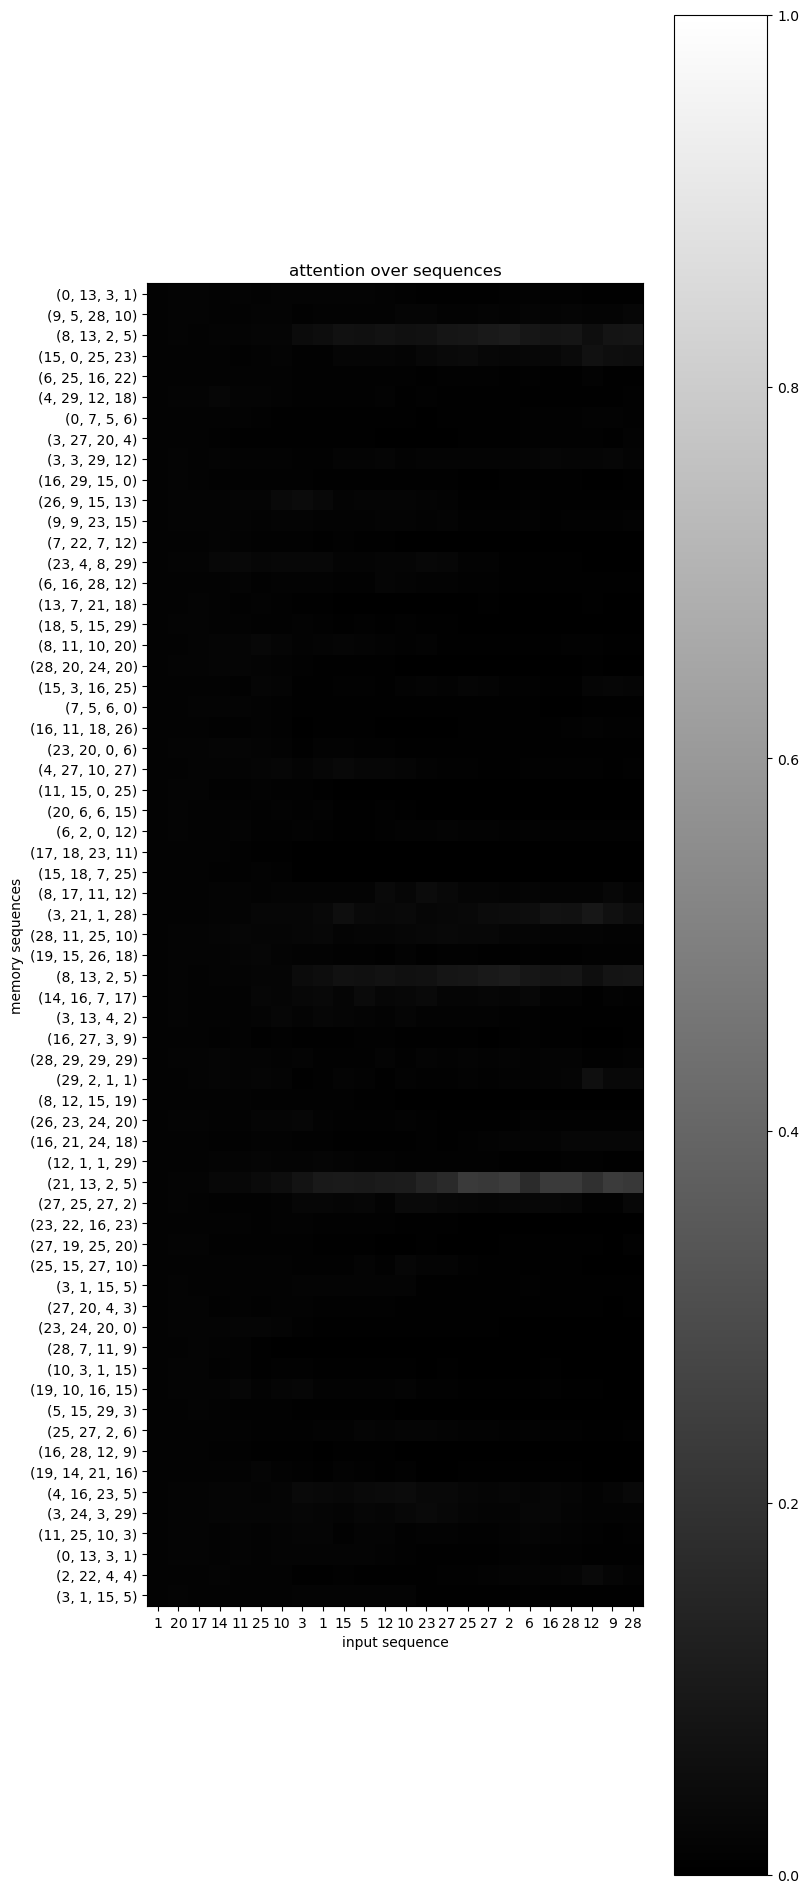

In [256]:
# testing set
for i in range(n_test-15, n_test):
    plot_attention(i, seqs_x_test, seqs_y_test, mem_seqs_x_train, mem_seqs_y_train, memory_model1)

sample_input:  [[ 4  8 29 15  0 25 23  8 22 10  1  8  8  8  8  8  8  8  8  8  8  8  8  8]]
prediction: [22 10 15  0 25 23  8 22 10  1  8  8  8  8  8  8  8  8  8  8  8  8  8  8]
y: [ 8 29 15  0 25 23  8 22 10  1  8  8  8  8  8  8  8  8  8  8  8  8  8  8]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[18 17 28 17 29 21 16 28 12  9 28 21 28 13 20 17 14 11 25 10  3  1 15  5]]
prediction: [20  4 19 29 21 13 28 12  9 28 21 28 13 20 17 14 11 25 10  3  1 15  5 12]
y: [17 28 17 29 21 16 28 12  9 28 21 28 13 20 17 14 11 25 10  3  1 15  5 12]
[False False False  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[ 5 11 17 20 29 10  0  7  5  6  0 13  3  1 15  5 12 10 23 27 25 27  2  6]]
prediction: [ 2  9 19  7 11 27  7  5  6  0 13  3  1 15  5 12 10 23 27 25 27  2  6 16]
y: [11 17 20 29 10  0

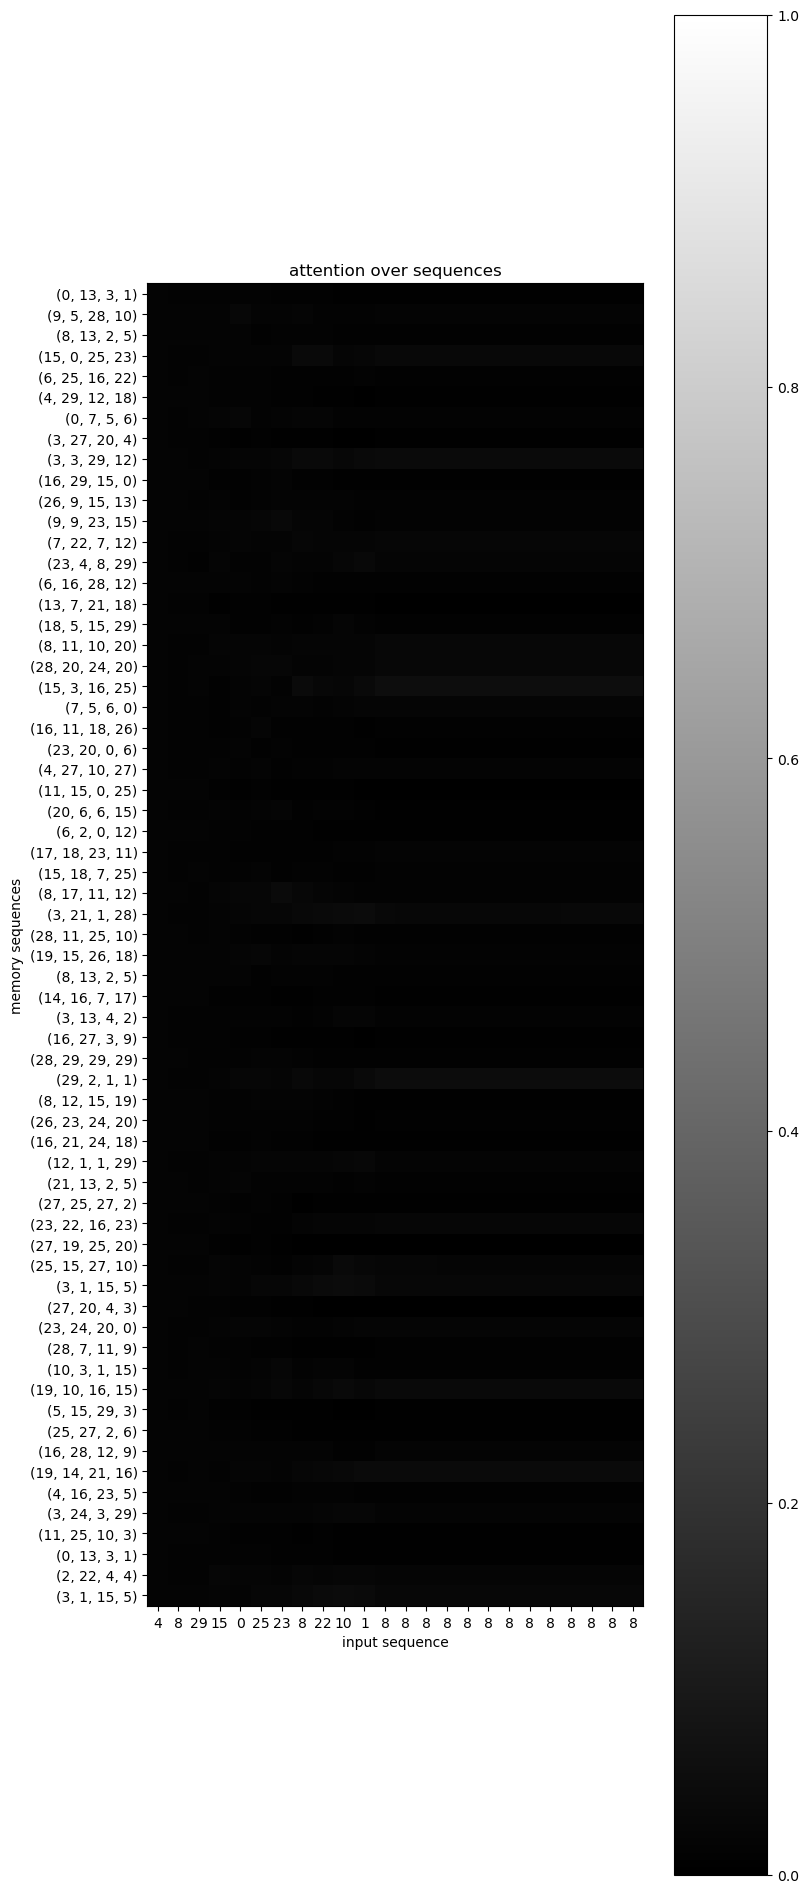

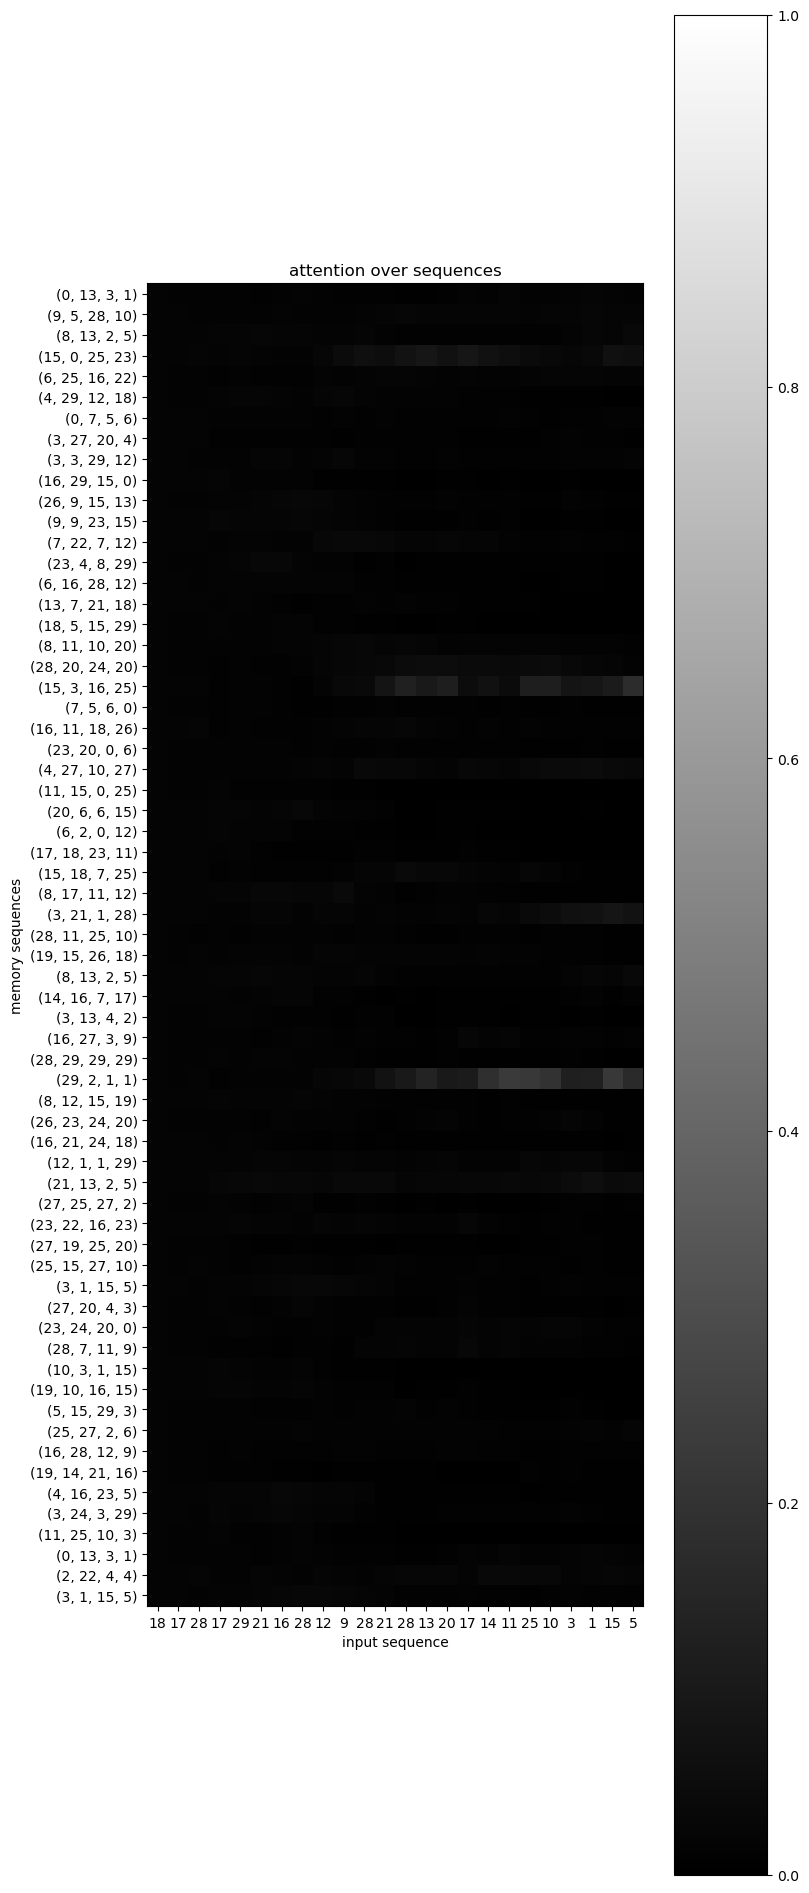

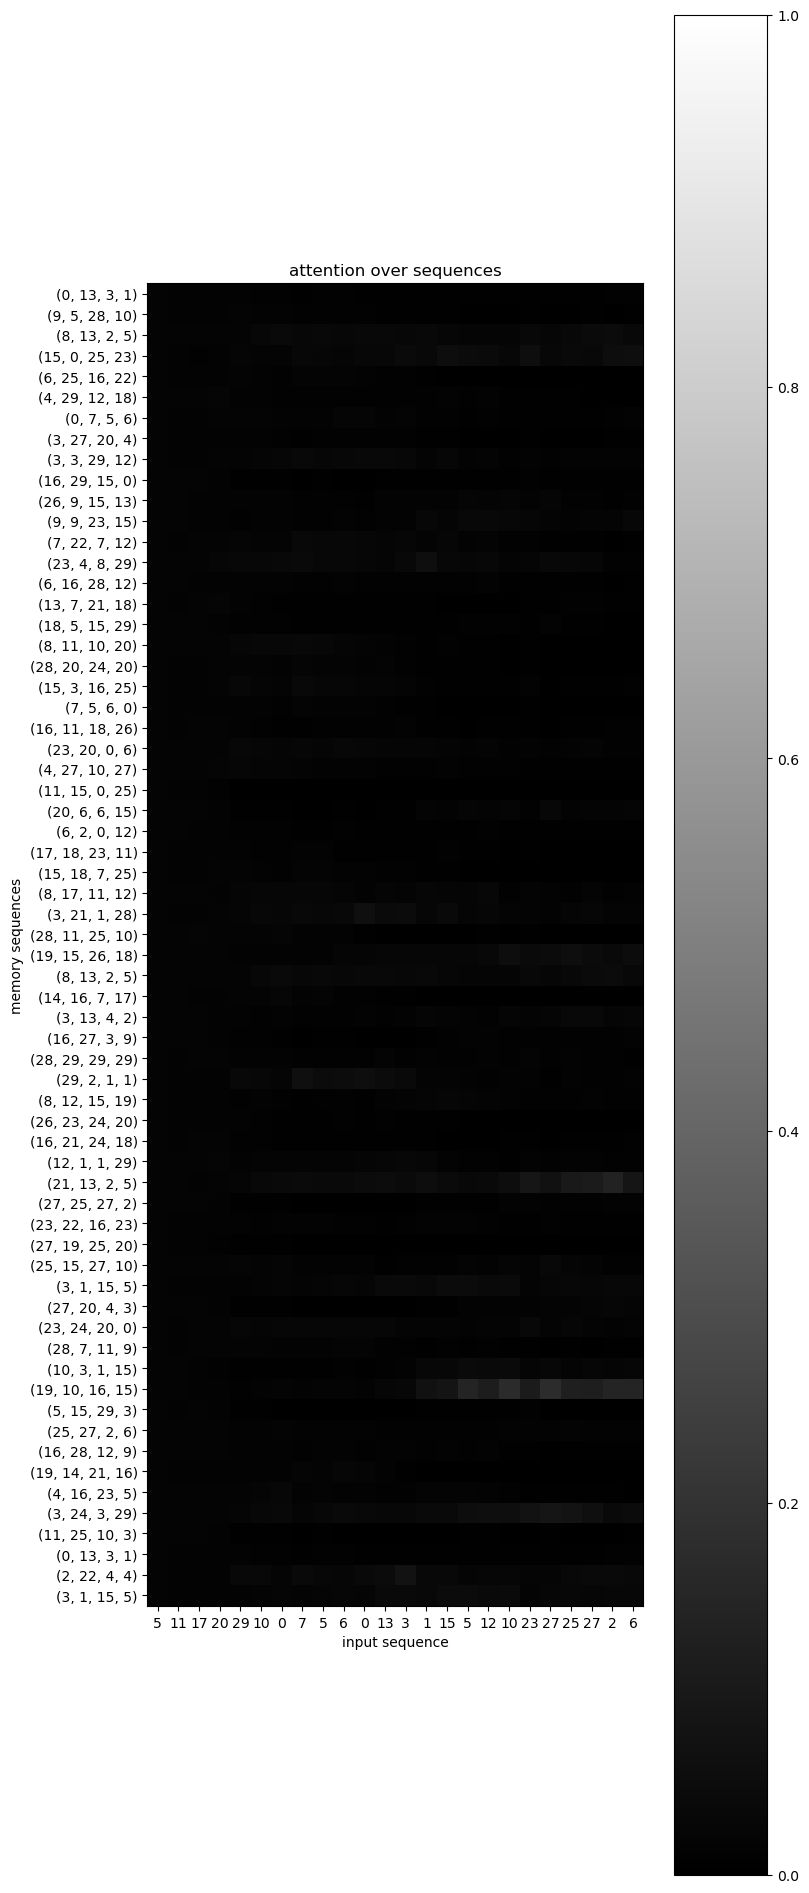

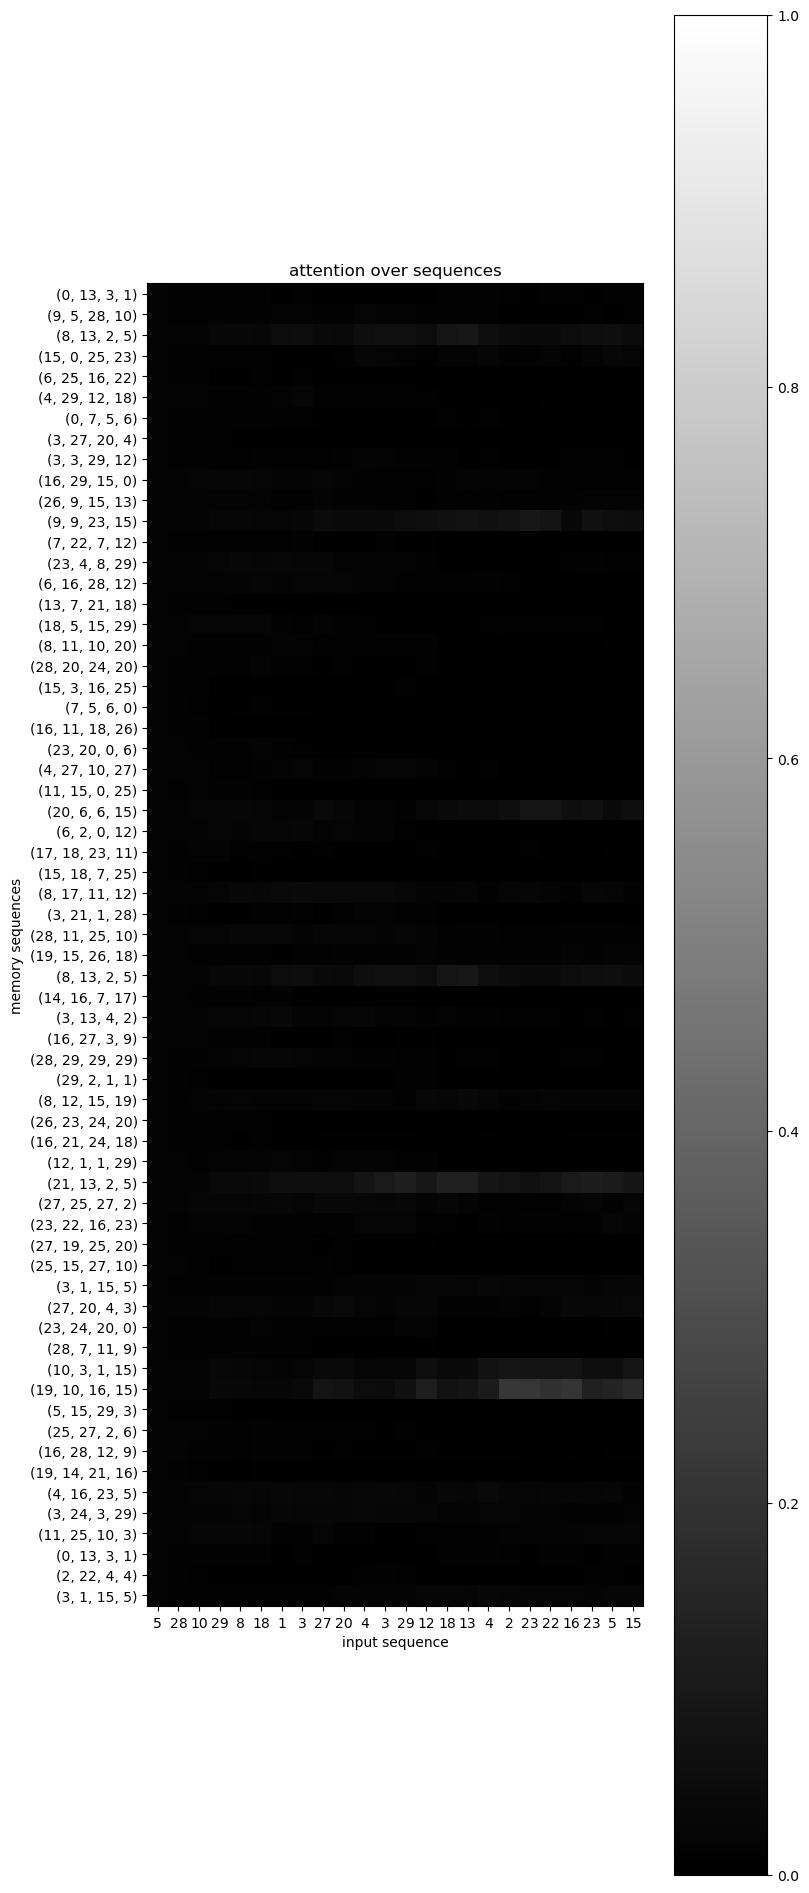

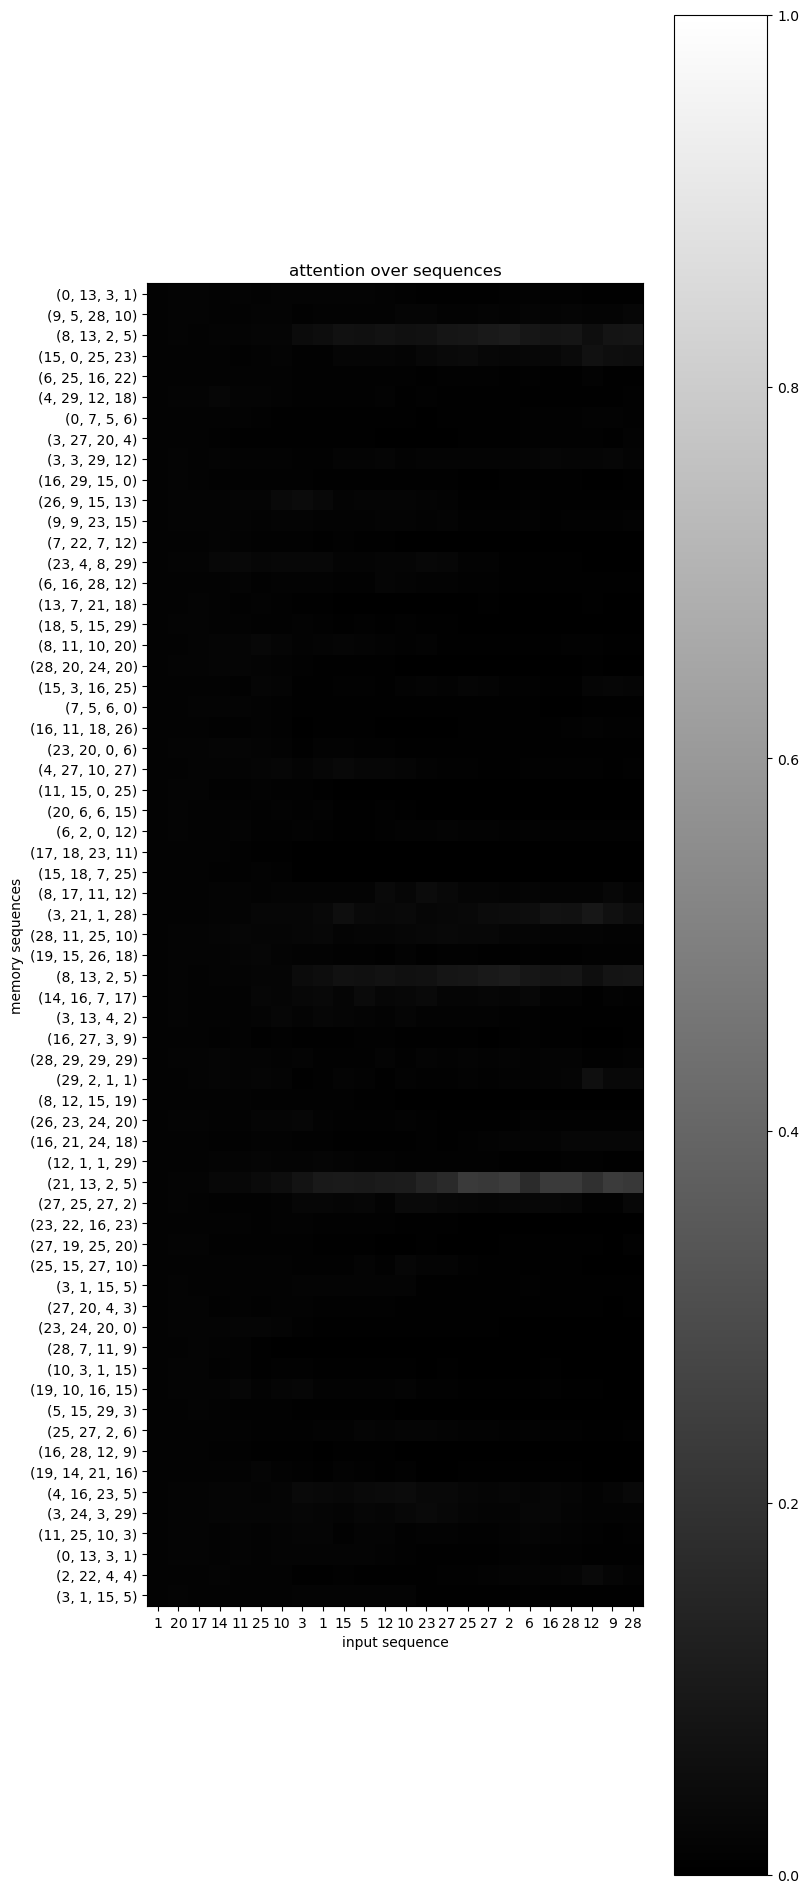

In [257]:
# attention on training set
for idx in [10,100,200, 300, 399]:
    plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_train, mem_seqs_y_train, memory_model1)


sample_input:  [[ 4  8 29 15  0 25 23  8 22 10  1  8  8  8  8  8  8  8  8  8  8  8  8  8]]
prediction: [22 10 15  0 25 23  8 22 10  1  8  8  8  8  8  8  8  8  8  8  8  8  8  8]
y: [ 8 29 15  0 25 23  8 22 10  1  8  8  8  8  8  8  8  8  8  8  8  8  8  8]
[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[18 17 28 17 29 21 16 28 12  9 28 21 28 13 20 17 14 11 25 10  3  1 15  5]]
prediction: [20  4 19 29 21 13 28 12  9 28 21 28 13 20 17 14 11 25 10  3  1 15  5 12]
y: [17 28 17 29 21 16 28 12  9 28 21 28 13 20 17 14 11 25 10  3  1 15  5 12]
[False False False  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[ 5 11 17 20 29 10  0  7  5  6  0 13  3  1 15  5 12 10 23 27 25 27  2  6]]
prediction: [ 2  9 19  7 11 27  7  5  6  0 13  3  1 15  5 12 10 23 27 25 27  2  6 16]
y: [11 17 20 29 10  0

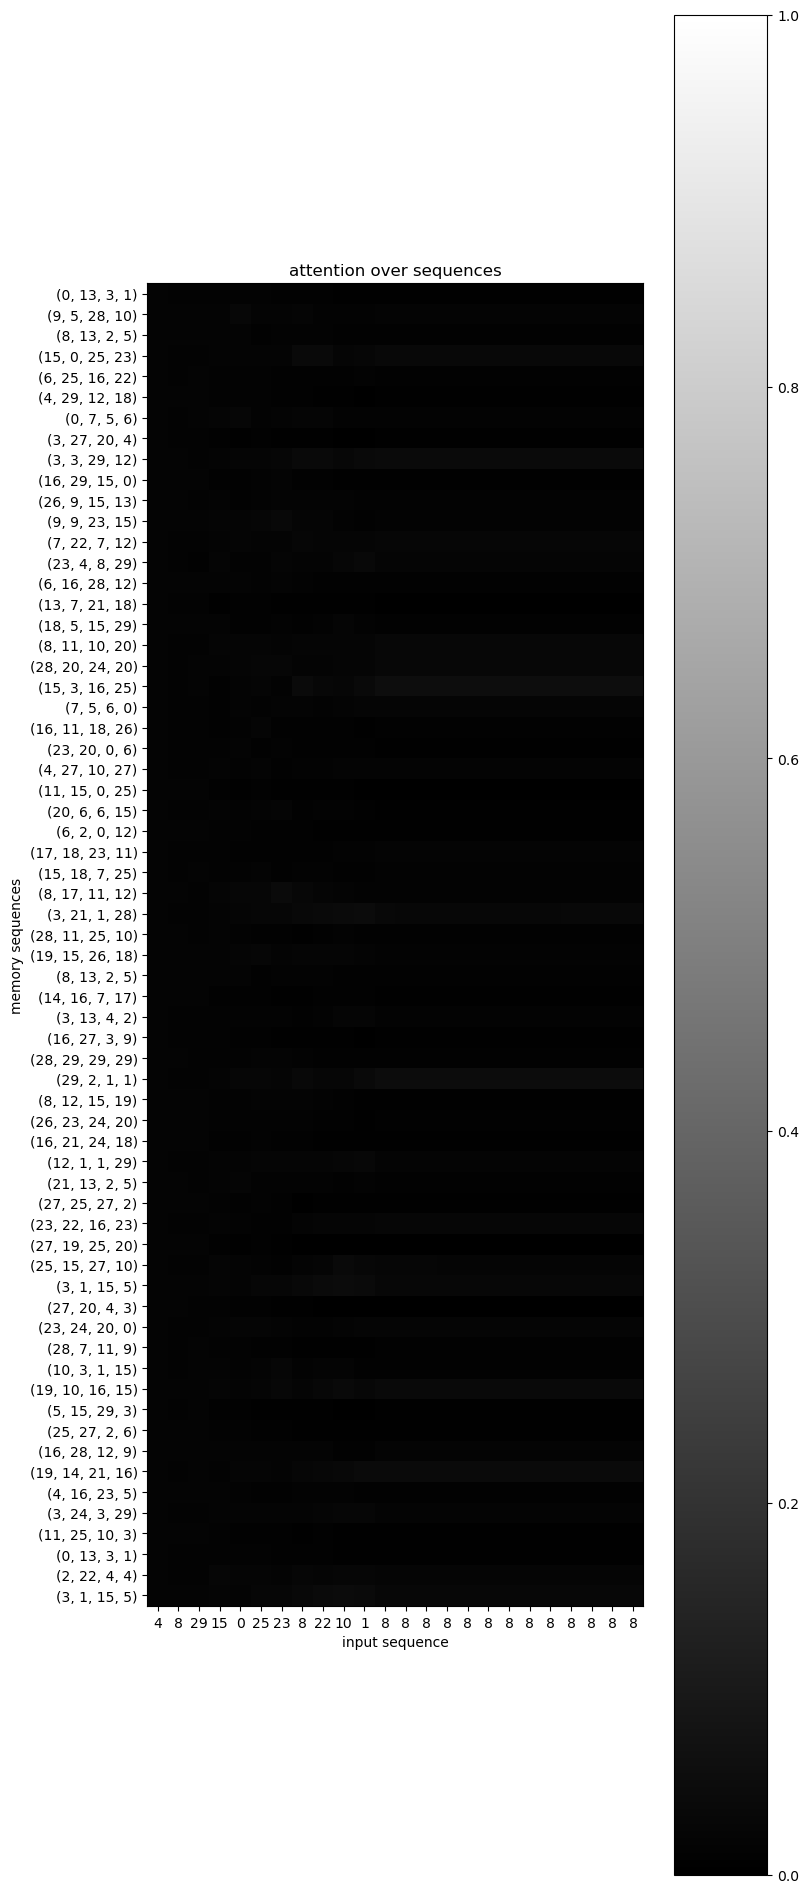

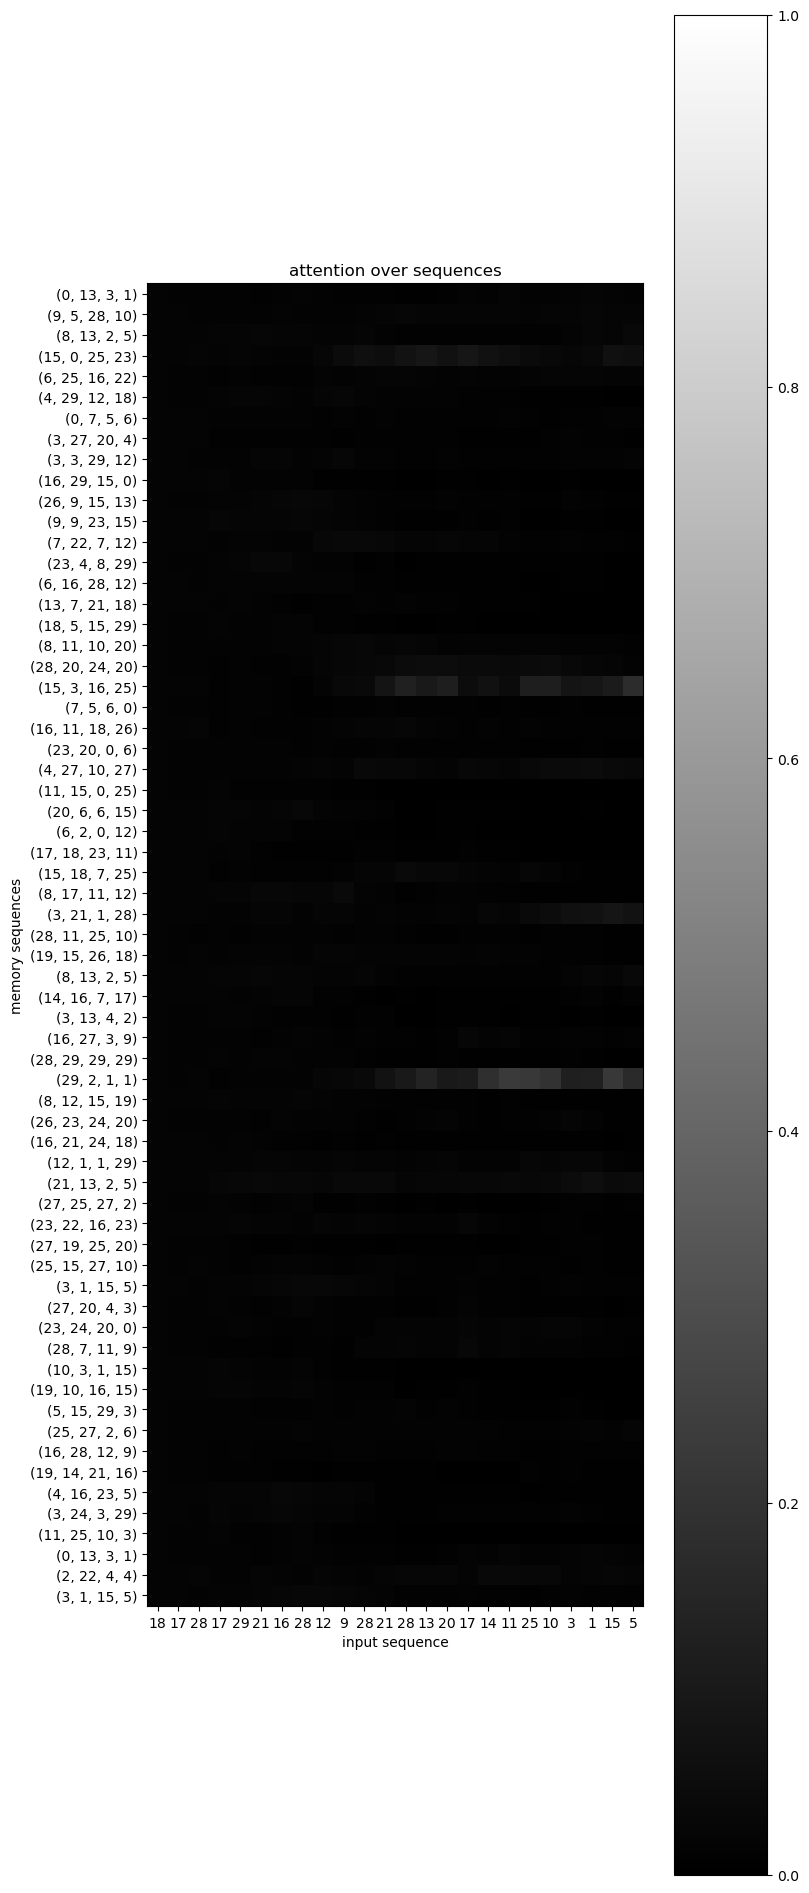

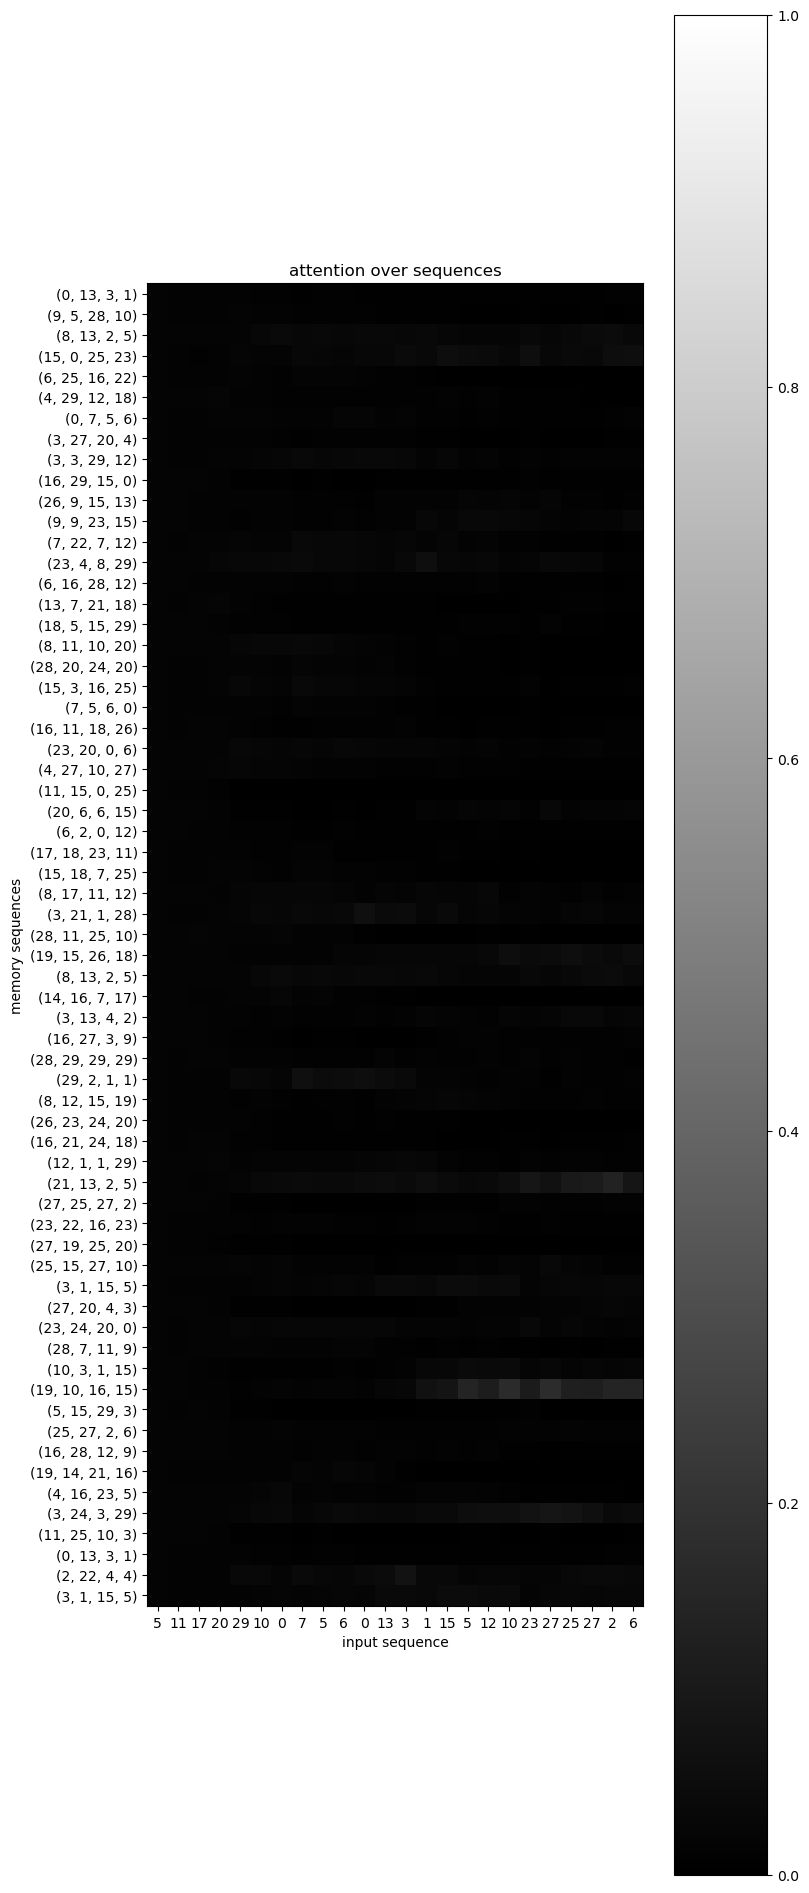

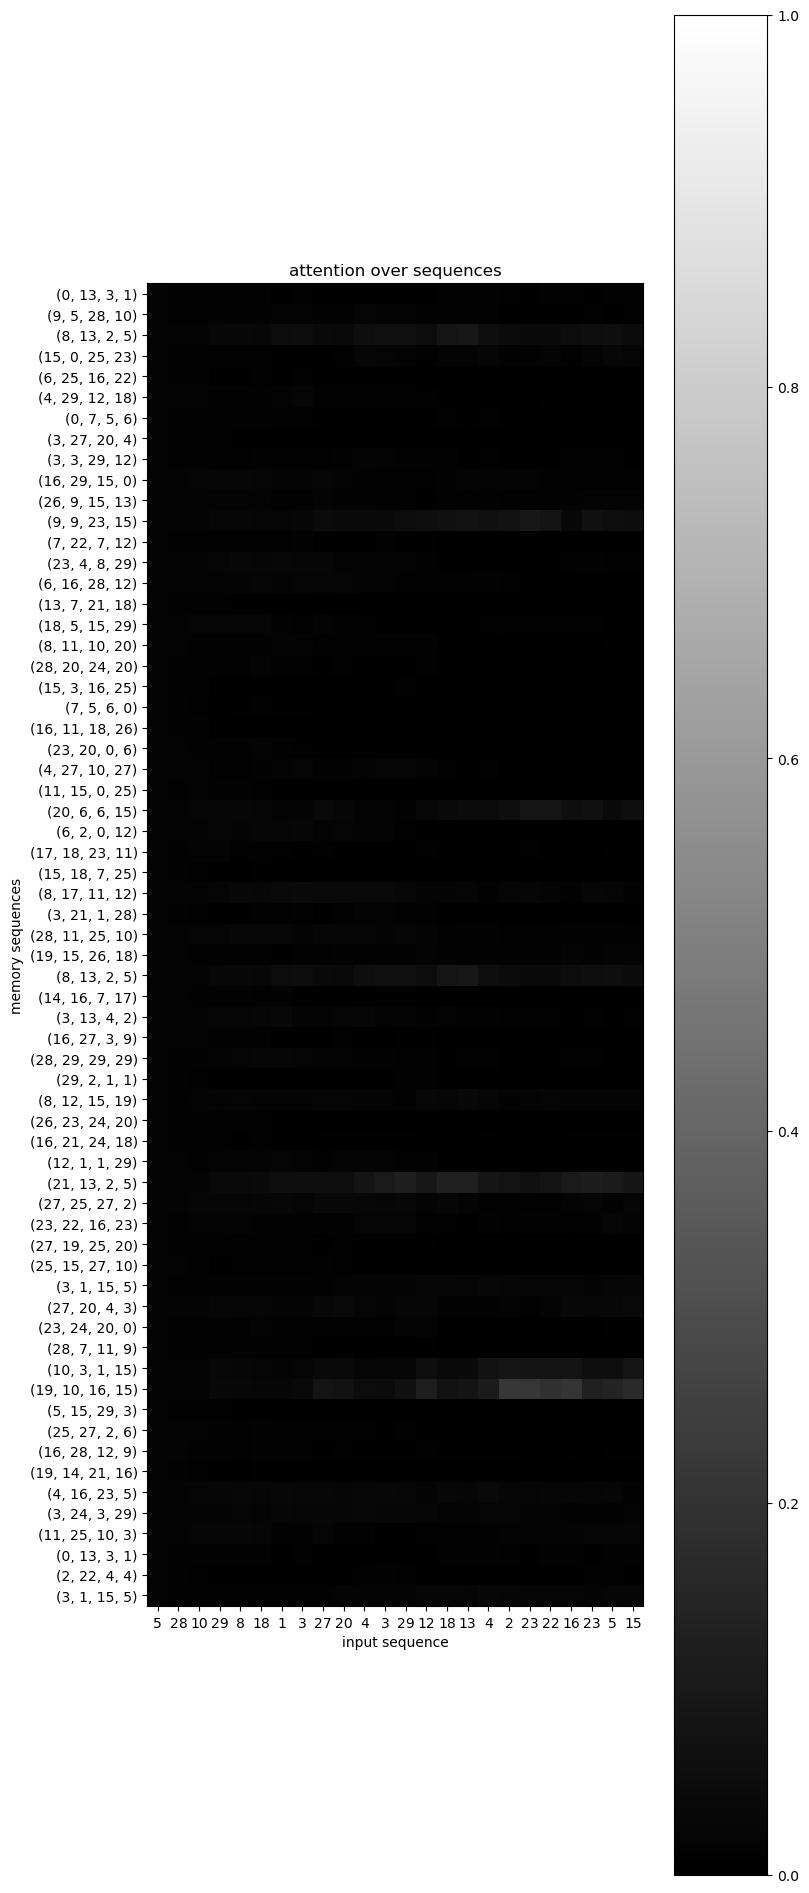

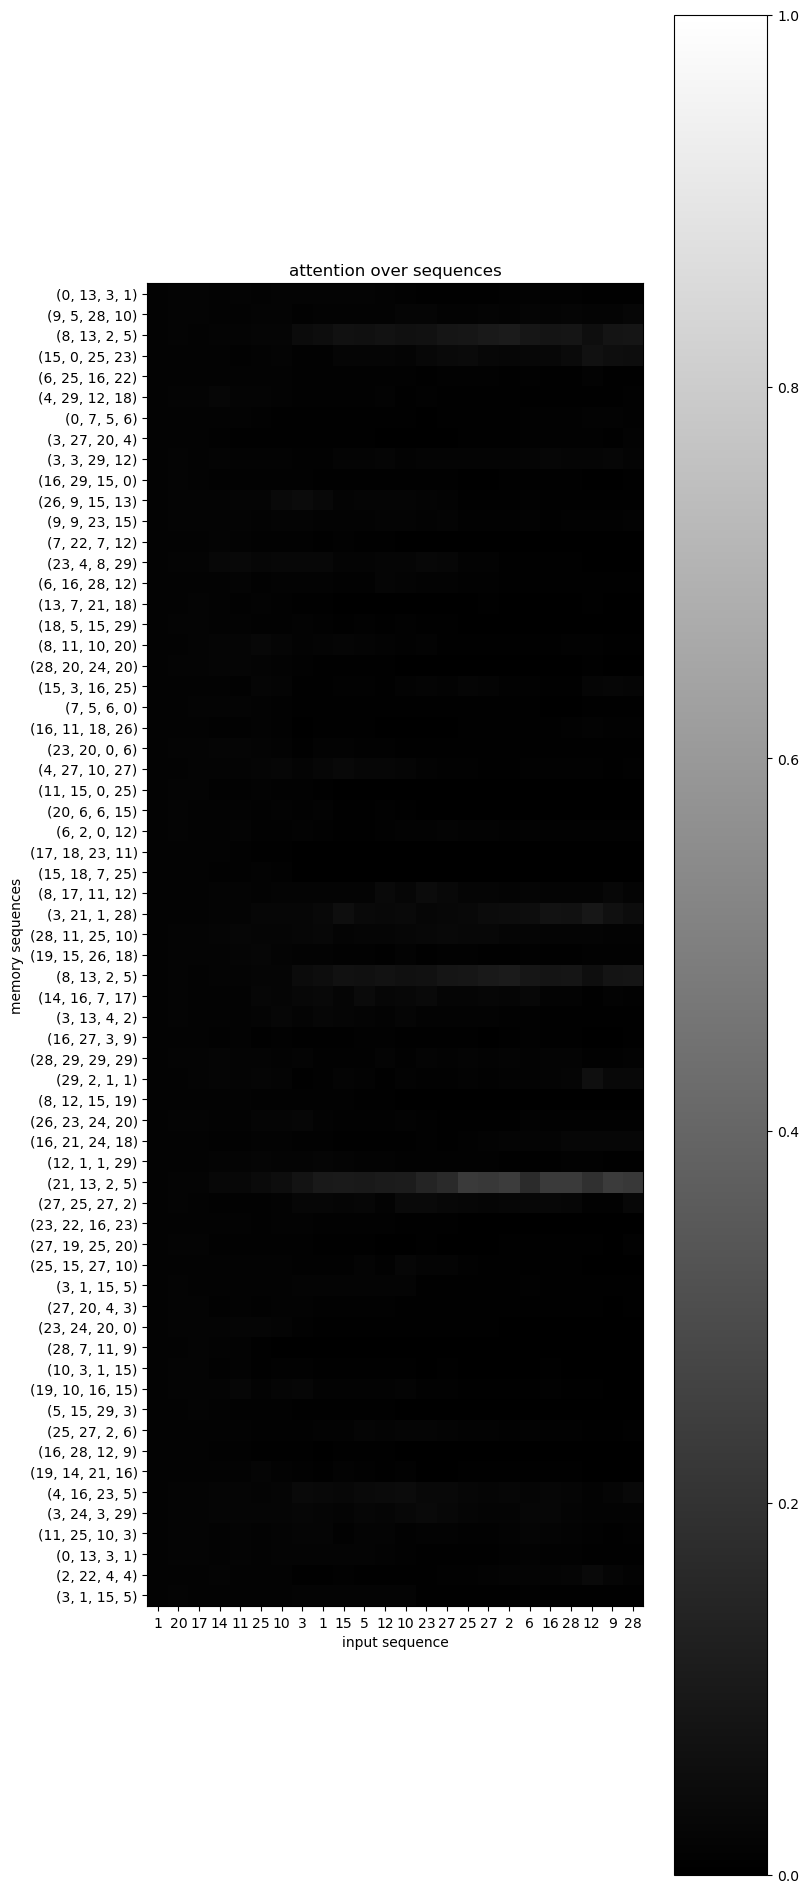

In [258]:
# attention on testing set
for idx in [10,100,200, 300, 399]:
    plot_attention(idx, seqs_x_test, seqs_y_test, mem_seqs_x_train, mem_seqs_y_train, memory_model1)
